<img src="https://i.imgur.com/MLND8w0.png">

<center><h1> I was warned </h1></center>
<center><h2> - but didn't listen 💧 - </h2></center>

> 📌 **Scope**: The [goal](https://www.kaggle.com/competitions/otto-recommender-system/data) of this competition is to predict e-commerce *clicks, cart additions, and orders*. You'll build a **multi-objective recommender system** based on previous events in a user session.

If you still are confused about the scope, I asked a [dumb question](https://www.kaggle.com/competitions/otto-recommender-system/discussion/367154) for myself too, so maybe this one will clear the air a bit more.

**Dataset**: The data I'm using is from [Radek's dataset here](https://www.kaggle.com/datasets/radek1/otto-full-optimized-memory-footprint).

**Additional Note**: As the data is 200 mil rows +, I did the preprocessing locally on my computer, so I will be also using my own dataset, but the original is still from Radek. :)

### ○ Libraries

Notebook Color Schemes:


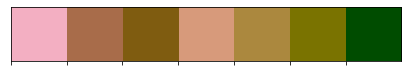

In [1]:
# General Libraries
import os
import re
import gc
import wandb
import random
import math
from tqdm import tqdm
from pprint import pprint
from time import time
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# RAPIDS
import cudf
import cupy

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'Otto', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
my_colors = ["#f3afc2", "#a86c4a", "#7f5c10", "#d79a7b", 
             "#ab883e", "#7a7300", "#004c00"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

### 🐝 W&B Fork & Run

In order to run this notebook you will need to input your own **secret API key** within the `! wandb login $secret_value_0` line. 

🐝**How do you get your own API key?**

Super simple! Go to **https://wandb.ai/site** -> Login -> Click on your profile in the top right corner -> Settings -> Scroll down to API keys -> copy your very own key (for more info check [this amazing notebook for ML Experiment Tracking on Kaggle](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases)).

<center><img src="https://i.imgur.com/fFccmoS.png" width=500></center>

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Secret_key")

In [3]:
! wandb login $secret_value_0

### ○ Helpers

In [4]:
# === General Functions ===

def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path, data_type="dataset"):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='Otto', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type=data_type)
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

In [5]:
# 🐝 Bonus: Cover Photo
run = wandb.init(project='Otto', name='CoverPhoto', config=CONFIG)
cover = plt.imread("../input/otto-helper-data/recsys_cover.png")
wandb.log({"cover": wandb.Image(cover)})
wandb.finish()

In [6]:
# 🐝 Experiment
run = wandb.init(project='Otto', name='base_info', config=CONFIG)

In [7]:
# 216 mil rows in train data
train = cudf.read_parquet("/kaggle/input/otto-full-optimized-memory-footprint/train.parquet")
test = cudf.read_parquet("/kaggle/input/otto-full-optimized-memory-footprint/test.parquet")

print(clr.S+"Train Shape:"+clr.E, train.shape)
print(clr.S+"Test Shape:"+clr.E, test.shape)

Train Shape: (216716096, 4)
Test Shape: (6928123, 4)


In [8]:
wandb.log({"train_len":train.shape[0],
           "test_len": test.shape[0]})

In [9]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [10]:
test.head()

,session,aid,ts,type
0,12899779,59625,1661724000,0
1,12899780,1142000,1661724000,0
2,12899780,582732,1661724058,0
3,12899780,973453,1661724109,0
4,12899780,736515,1661724136,0


In [11]:
wandb.finish()

# 1.Sessions x Events

> 📌**Note**: There is no intersection in the sessions from `train` and `test` datasets. All sessions in the `test` dataset are unique (and truncated in time).

*FYI, as I've seen in Discussions, a session is a user. So each unique session is actually a unique user - meaning there are no 2 sessions from 1 person in time.*

In [12]:
# 🐝 Experiment
run = wandb.init(project='Otto', name='session_look', config=CONFIG)

In [13]:
# Intersection between sessions in train vs test = 0
# which means all users in test data are NEW
set(train["session"].to_pandas()).intersection(set(test["session"].to_pandas()))

set()

In [14]:
def get_describe(x):
    '''Get .describe() info.'''
    return {"mean": x.mean(),
            "min": x.min(),
            "max": x.max(),
            "count": len(x)}

sess_tr = train["session"].value_counts().values
sess_te = test["session"].value_counts().values

In [15]:
print(clr.S+"=== Train ==="+clr.E)
print(clr.S+"Event Number Summary per Session"+clr.E)
print(get_describe(sess_tr.get()))
wandb.log(get_describe(sess_tr.get()))

print(clr.S+"=== Test ==="+clr.E)
print(clr.S+"Event Number Summary per Session"+clr.E)
print(get_describe(sess_te.get()))

=== Train ===
Event Number Summary per Session
{'mean': 16.799985178040647, 'min': 2, 'max': 500, 'count': 12899779}
=== Test ===
Event Number Summary per Session
{'mean': 4.144102504900398, 'min': 1, 'max': 458, 'count': 1671803}


In [ ]:
print(clr.S+"- Percent of Sessions in Terms of Event Numbers -"+clr.E)

print(clr.S+"=== Train ==="+clr.E)
print("<10 events:", sum(sess_tr<10)/get_describe(sess_tr)["count"], "\n"+
      "<50 events:", sum(sess_tr<50)/get_describe(sess_tr)["count"], "\n"+
      "<150 events:", sum(sess_tr<150)/get_describe(sess_tr)["count"], "\n"+
      "150 events or more:", sum(sess_tr>=150)/get_describe(sess_tr)["count"])

print(clr.S+"=== Test ==="+clr.E)
print("<10 events:", sum(sess_te<10)/get_describe(sess_te)["count"], "\n"+
      "<50 events:", sum(sess_te<50)/get_describe(sess_te)["count"], "\n"+
      "<150 events:", sum(sess_te<150)/get_describe(sess_te)["count"], "\n"+
      "150 events or more:", sum(sess_te>=150)/get_describe(sess_te)["count"])

- Percent of Sessions in Terms of Event Numbers -
=== Train ===


**Train Overview**:
* There are 12,899,779 unique sessions (a session ~ a user) in the `train` data
* The *average* number of events (clicks, added to cart, ordered) is ~17
* ~63% of sessions have *less than 10 events*
* ~92% of sessions have *less than 50 events*
* ~98% of sessions have *less than 150 events*
* ~2% of sessions have *very high engagement* aka events (more than 150 per session)

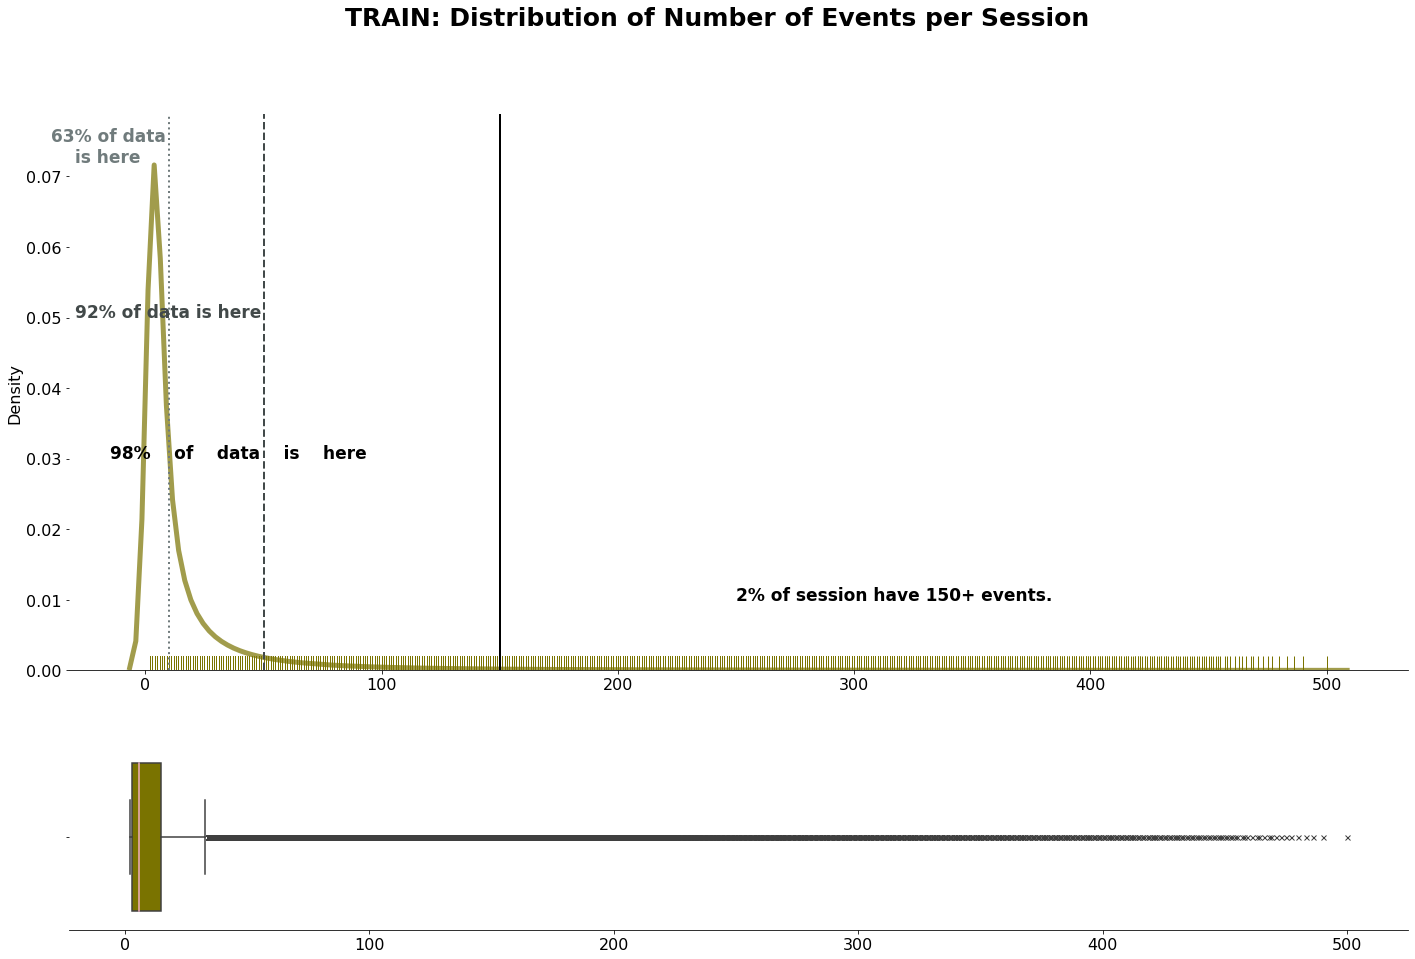

In [16]:
sess = sess_tr[::60].copy()
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(sess.get(), rug=True, hist=False, 
#              bins=10,
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[5]},
             ax=a0)

a0.axvline(x=10, ls=":", lw=2, color="#707B7C")
a0.text(x=-40, y=0.075, s="63% of data", size=17, color="#707B7C", weight="bold")
a0.text(x=-30, y=0.072, s="is here", size=17, color="#707B7C",weight="bold")
a0.axvline(x=50, ls="--", lw=2, color="#424949")
a0.text(x=-30, y=0.05, s="92% of data is here", size=17, color="#424949", weight="bold")
a0.axvline(x=150, ls="-", lw=2, color="black")
a0.text(x=-15, y=0.03, s="98%    of    data    is    here", size=17, weight="bold")
a0.text(x=250, y=0.01, s="2% of session have 150+ events.", size=17,weight="bold")

sns.boxplot(x=sess.get(), ax=a1, notch=False, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": my_colors[5]},
            medianprops={"color": my_colors[0]},)

plt.suptitle("TRAIN: Distribution of Number of Events per Session", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [17]:
create_wandb_hist(x_data=sess.tolist(), 
                  x_name="Number of Events / Session",
                  title="TRAIN: Distribution of Number of Events per Session",
                  log="hist_sess_train")

**Test Overview**:
* There are 1,671,803 unique sessions (a session ~ a user)
* The session length is much smaller, with an average of 4 events (~3 times smaller than for `train`)
* There are some longer sessions that should not be disregarded? ***

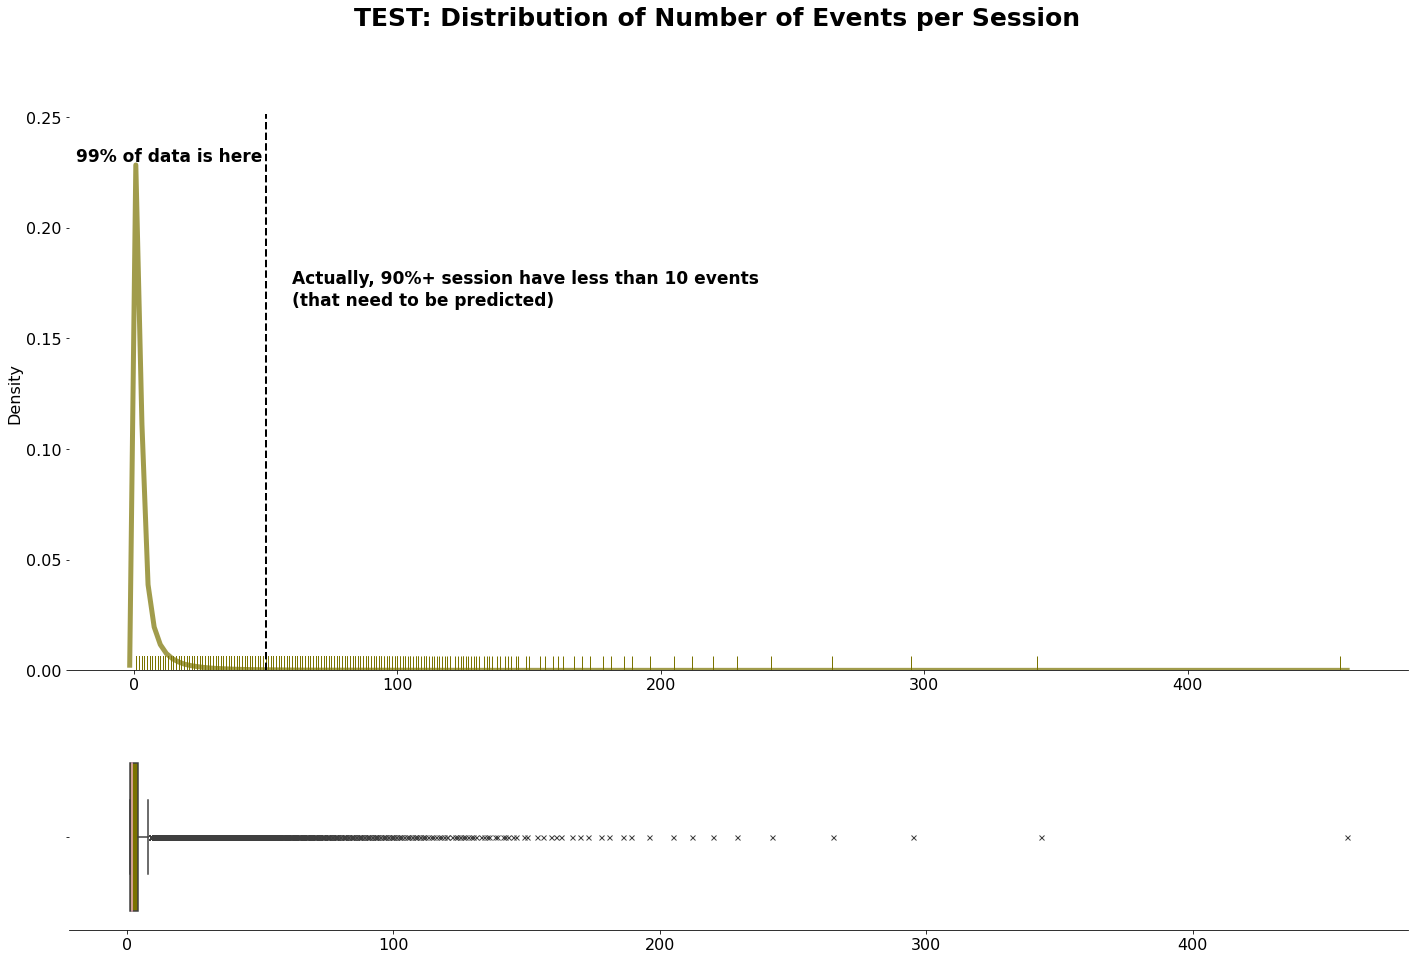

In [18]:
sess = sess_te[::20].copy()
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(sess.get(), rug=True, hist=False, 
#              bins=10,
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[5]},
             ax=a0)

a0.axvline(x=50, ls="--", lw=2, color="black")
a0.text(x=-22, y=0.23, s="99% of data is here", size=17, color="black", weight="bold")
a0.text(x=60, y=0.175, s="Actually, 90%+ session have less than 10 events", size=17, 
        color="black", weight="bold")
a0.text(x=60, y=0.165, s="(that need to be predicted)", size=17, color="black", weight="bold")

sns.boxplot(x=sess.get(), ax=a1, notch=False, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": my_colors[5]},
            medianprops={"color": my_colors[0]},)

plt.suptitle("TEST: Distribution of Number of Events per Session", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [19]:
create_wandb_hist(x_data=sess.tolist(), 
                  x_name="Number of Events / Session",
                  title="TEST: Distribution of Number of Events per Session",
                  log="hist_sess_test")

In [20]:
wandb.finish()

# 2. Types of Events

📍 **3 Types of Events** (encoded numericaly for memory convenience): 
* 0: clicks
* 1: carts (added to cart)
* 2: orders

In [21]:
# 🐝 Experiment
run = wandb.init(project='Otto', name='event_look', config=CONFIG)

In [22]:
# See percentage of events as clicks, carts, orders
types = train["type"].value_counts().reset_index()
types.columns = ["type", "train"]
types["test"] = test["type"].value_counts().values

total_tr = types["train"].sum()
total_te = types["test"].sum()
types["train"] = (types["train"]/total_tr)*100
types["test"] = (types["test"]/total_te)*100

types = types.melt(id_vars=["type"], 
                   var_name="Data", 
                   value_name="Count")

types

,type,Data,Count
0,0,train,89.850714
1,1,train,7.796464
2,2,train,2.352825
3,0,test,90.827371
4,1,test,8.227495
5,2,test,0.945133


In [23]:
# See how many sessions contain distinct events
distincts = train.groupby("session")["type"].nunique()\
                .reset_index()["type"].value_counts().reset_index()
distincts.columns = ["unique_events", "train"]
distincts["test"] = test.groupby("session")["type"].nunique()\
                        .reset_index()["type"].value_counts().values

total_tr = distincts["train"].sum()
total_te = distincts["test"].sum()
distincts["train"] = (distincts["train"]/total_tr)*100
distincts["test"] = (distincts["test"]/total_te)*100

distincts = distincts.sort_values("unique_events").reset_index(drop=True)

distincts = distincts.melt(id_vars=["unique_events"], 
                           var_name="Data", 
                           value_name="Count")

distincts

,unique_events,Data,Count
0,1,train,70.180350
1,2,train,17.490951
2,3,train,12.328700
3,1,test,85.392238
4,2,test,12.642399
5,3,test,1.965363


**Event Types Analysis**:
* `train` and `test` have around the same distribution
* 90% of events are clicks, ~7% are "add to carts" and 2% are actual "orders". There is also a *very low percentage* of orders in `test` set.
* unique event count:
    * for train: 
        * 70% of sessions have only 1 event type
        * 17% of sessions have 2 event types
        * 12% of sessions have all 3 event types
    * for test:
        * 85% of sessions have only 1 event type (much higher than for train)
        * 12% of sessions have 2 event types
        * 1% of sessions have all 3 event types (much lower than for train - as number of orders in test is also much lower)
* *Big difference between train and test

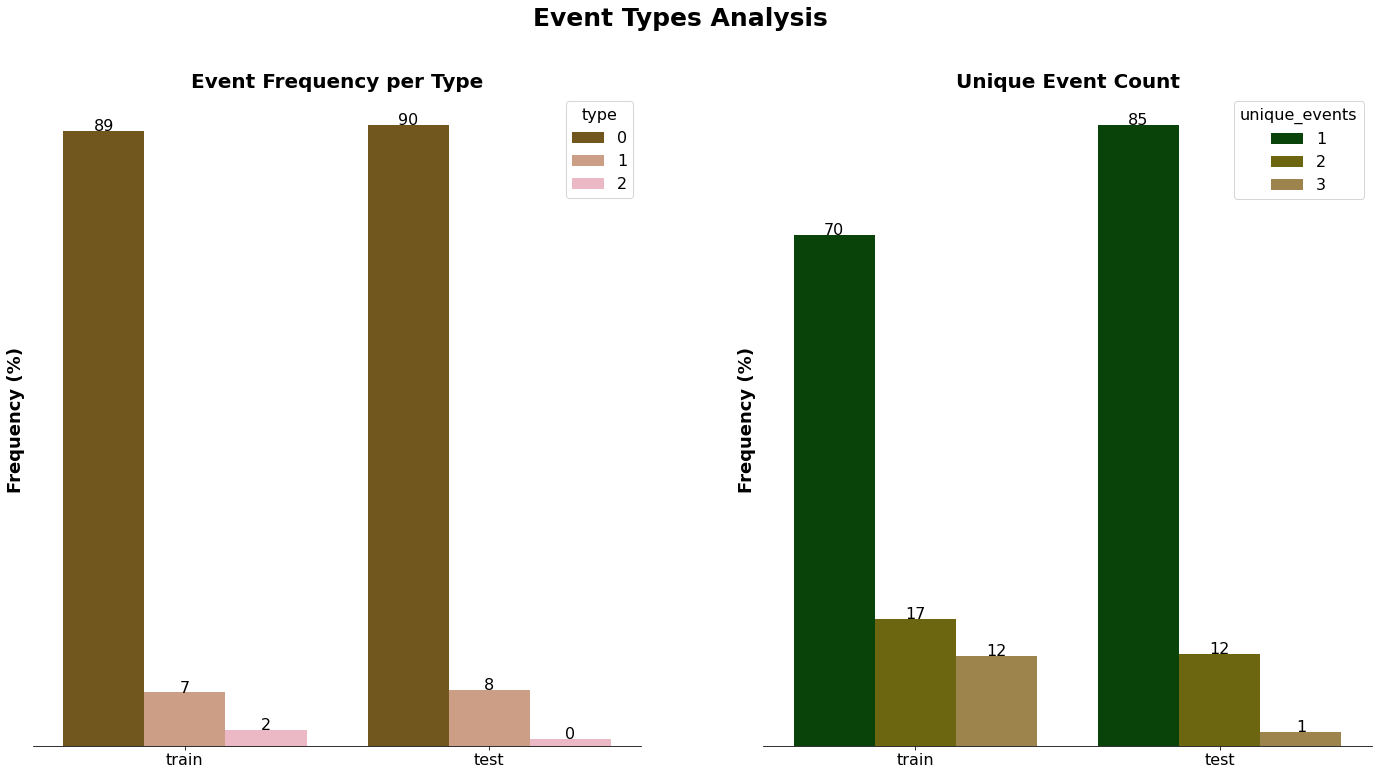

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
axs = [ax1, ax2]
fig.suptitle('Event Types Analysis', 
             weight="bold", size=25)

sns.barplot(data=types.to_pandas(), x="Data", y="Count", hue="type", ax=ax1,
            palette=[my_colors[2], my_colors[3], my_colors[0]])
show_values_on_bars(ax1, h_v="v", space=0.4)
ax1.set_title('Event Frequency per Type', weight="bold", size=20)

sns.barplot(data=distincts.to_pandas(), x="Data", y="Count", hue="unique_events", ax=ax2,
            palette=[my_colors[6], my_colors[5], my_colors[4]])
show_values_on_bars(ax2, h_v="v", space=0.4)
ax2.set_title('Unique Event Count', weight="bold", size=20)

for ax in axs:
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Frequency (%)", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

Now I wanted to look on session level (not overall) how do the users behave.
* 9 mil sessions did only **1 type of activity** (either click, cart or order).
* 2.2 mil session did **2 types of events**
* only 1.5 sessions have **all 3 activities**

In [25]:
session_type = train.groupby(["session"])["type"].nunique().reset_index()
session_type.columns = ["session", "types_count"]

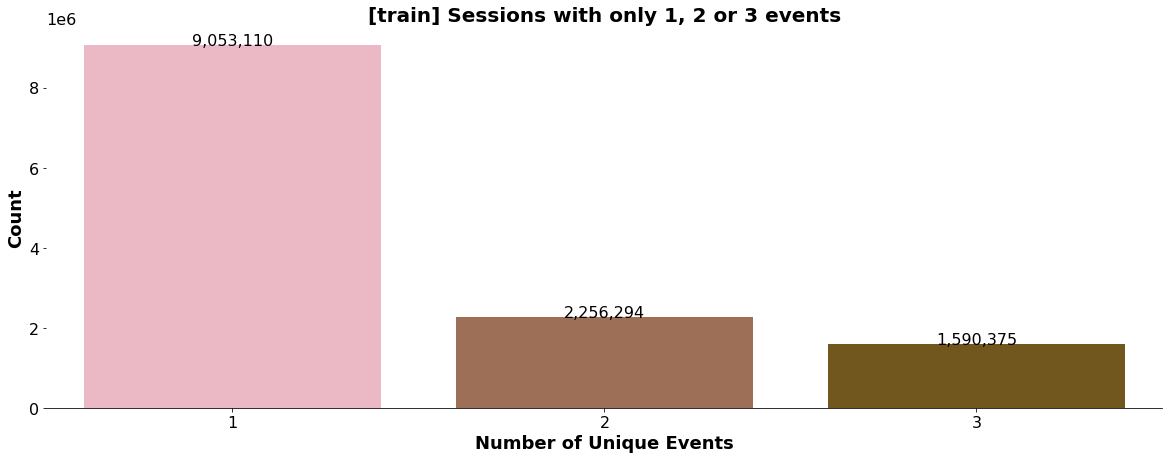

In [26]:
plt.figure(figsize=(20, 7))

figure = sns.barplot(data=session_type["types_count"].value_counts().reset_index().to_pandas(),
                     x="index", y="types_count", palette=my_colors)
show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[train] Sessions with only 1, 2 or 3 events', weight="bold", size=20)

plt.xlabel("Number of Unique Events", size = 18, weight="bold")
plt.ylabel("Count", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [27]:
create_wandb_plot(x_data=session_type["types_count"].value_counts().reset_index().to_pandas()["index"],
                  y_data=session_type["types_count"].value_counts().reset_index().to_pandas()["types_count"],
                  x_name="Number of Unique Events", y_name="Count",
                  title="[train] Sessions with only 1, 2 or 3 events",
                  log="bar_sess_type", plot="bar")

**Q**: Is a pattern between clicks carts orders? Is an item after a certain amount of clicks added to cart?

> **Note**: unfortunatelly here I get OOM error when trying to filter the `train` dataset on only the sessions that contain at least 1 order in them. Hence, back to local work it is! The result (3 rows) of information that I got locally I just pasted after the function `get_order_behavior()` that I used on my machine.

In [28]:
# First, let's select only sessions that have at least 1 order in them
sess_list = train[train["type"]==2]["session"].unique().values.tolist()
print(clr.S+"No. of Session with at least 1 order in them:"+clr.E, len(sess_list))

No. of Session with at least 1 order in them: 1626338


In [29]:
# List with all aids that are present in orders
aid_list = train[train["type"]==2]["aid"].unique().values.tolist()
print(clr.S+"No. of Aids that are present in orders:"+clr.E, len(sess_list))

No. of Aids that are present in orders: 1626338


In [30]:
def get_order_behavior(train):
    
    # Select only sessions that contain at least 1 order in them
    # and only AIDs (products) that appear in an order
    data = train[(train["session"].isin(sess_list)) & (train["aid"].isin(aid_list))]\
                        .reset_index(drop=True)

    # List of sessions that have more than 50 events
    # as we established all these sessions are outliers and might
    # hence we want to EXCLUDE them to not mess up our averages afterwards
    outliers = train["session"].value_counts().reset_index()
    outliers = outliers[outliers["session"]>=50]["index"].unique().tolist()
    data = data[~data["session"].isin(outliers)]

    # On average how many clicks/ how many carts does it take to make an order?
    final = data.groupby(["session", "aid", "type"])["night"].count().reset_index().\
                groupby(["aid", "type"])["night"].mean().reset_index().\
                groupby(["type"])["night"].mean()
    
    return final

# Function ran locally (Kaggle env out of memory error) - result can be seen below
final = pd.DataFrame({"type": [0, 1, 2],
                      "average": [1.573084, 1.167270, 1.051570]})

So, what was the question again?

**Q**: Is a pattern between clicks carts orders? Is an item after a certain amount of clicks added to cart?

**A**: So, what I wanted to check with my question was if users click multiple times before they order. E.g. if you want a speciffic aid, do you go and click on it 3 times to "make sure" you like it before you order? The answer is ... kinda no? It takes 1.57 clicks (so I would say some users click twice, some only once) for a user to actually purchase the item. 

*(keeping in mind I have *removed* all sessions that had 50+ events, as these were outliers that would have messed up with my average)*

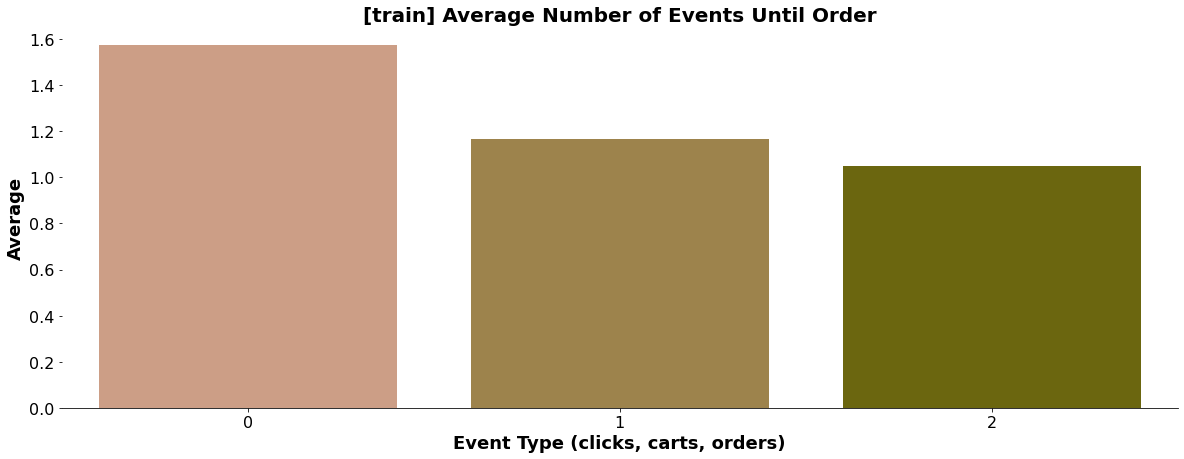

In [31]:
plt.figure(figsize=(20, 7))

figure = sns.barplot(data=final,
                     x="type", y="average", palette=my_colors[3:])
# show_values_on_bars(figure, h_v="v", space=0.4)
plt.title('[train] Average Number of Events Until Order', weight="bold", size=20)

plt.xlabel("Event Type (clicks, carts, orders)", size = 18, weight="bold")
plt.ylabel("Average", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [32]:
create_wandb_plot(x_data=final["type"],
                  y_data=final["average"],
                  x_name="Event Type (clicks, carts, orders)", y_name="Average",
                  title="[train] Average Number of Events Until Order",
                  log="bar_until_order", plot="bar")

> 📍 **Bonus**: As stated before, I have excluded the outliers from the data, so they don't mess up my average. However, locally, out of fun, I wanted to see what it would happen if I would keep the outliers. Would my numbers change completely? And the answer is no, the number of clicks changes only slighlty, from 1.57 to 1.70. When looking closely to the data, **there is rarely the case when an `aid` repeats more than 2-3 times per session**. This is actually very interesting (as my behavior for example is usually to recheck a product multiple times, go back and forth before buying).

In [33]:
wandb.finish()

In [34]:
del sess, train, test, session_type, aid_list
gc.collect()

5340

# 3. Time

**Some of my questions:**
* What is the timeline of sessions for train and test?
* Is there less or more activity during the night?
* How does the number of sessions group over time? (aka are they more condensed in certain periods or they are equaly distributed?)

📍**Keep in mind**: as the Kaggle kernel does not have enough compute power and memory to perform the following tasks (converting Unix timestamp to datetime, getting the month, day, hour etc. to perform further analytics), I have done the following `get_datetime_info()` function locally and saved the data in [my dataset](https://www.kaggle.com/datasets/andradaolteanu/otto-helper-data). I've used `parallel_apply()` to compute them faster, this and `RAPIDS` library have been of real help for the huge amount of data we're handling in this competition.

<center><img src="https://i.imgur.com/qF8C6sQ.png" width=800></center>

In [35]:
# 🐝 Experiment
run = wandb.init(project='Otto', name='time_look', config=CONFIG)

> 📍 **Note** - do NOT divide by /1000 if you're using Radek's dataset, as he already did that. :) Otherwise you'll get data starting from 1970 and you'll wonder (like I did) if we went back in time.

In [36]:
# Simple function
def get_time(x):
    '''Convert from Unix to Datetime.'''
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

# With parallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

def get_time_parallel(row):
    '''Convert from Unix to Datetime.'''
    return datetime.utcfromtimestamp(row.ts).strftime('%Y-%m-%d %H:%M:%S')

def get_night(x):
    night = [21, 22, 23, 0, 1, 2, 3, 4, 5]
    
    if x in night:
        return 1
    else:
        return 0

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [37]:
def get_datetime_info(df):
    df["datetime"] = cudf.Series(df.to_pandas().parallel_apply(get_time_parallel, axis=1))

    df["datetime"] = cudf.to_datetime(df["datetime"])

    # Get day to retrieve activity
    df["day"] = df["datetime"].dt.day
    df["month"] = df["datetime"].dt.month
    df["weekday"] = df["datetime"].dt.weekday
    df["hour"] = df["datetime"].dt.hour
    
    df["night"] = cudf.Series(df["hour"].to_pandas().apply(lambda x: get_night(x)))
    
    df.drop(columns=["datetime"], inplace=True)
    
    return df

In [38]:
# Read in prepped data - made locally using the above function
train = cudf.read_parquet("/kaggle/input/otto-helper-data/train_prep.parquet")
test = cudf.read_parquet("/kaggle/input/otto-helper-data/test_prep.parquet")

train.head()

,session,aid,ts,type,day,month,weekday,hour,night
0,0,1517085,1659304800,0,31,7,6,22,1
1,0,1563459,1659304904,0,31,7,6,22,1
2,0,1309446,1659367439,0,1,8,0,15,0
3,0,16246,1659367719,0,1,8,0,15,0
4,0,1781822,1659367871,0,1,8,0,15,0


**Q**: What is the **timeline** of sessions for train and test?

**A**: The dataset starts from 31 July 2022 midnight and goes for 1 month, until 28 Aug 2022 for the training part. For the test part we need to predict 1 week in the future, from 28 Aug (where we left off during train) until 4 Sep 2022.

In [39]:
print(clr.S+"Start Train:"+clr.E, get_time(train["ts"].min()), "\n"+
      clr.S+"Finish Train:"+clr.E, get_time(train["ts"].max()), "\n"+
      clr.S+"Start Test:"+clr.E, get_time(test["ts"].min()), "\n"+
      clr.S+"Finish Test:"+clr.E, get_time(test["ts"].max()))

Start Train: 2022-07-31 22:00:00 
Finish Train: 2022-08-28 21:59:59 
Start Test: 2022-08-28 22:00:00 
Finish Test: 2022-09-04 21:59:51


**Q**: How does the **number of sessions group over time**? (aka are they more condensed in certain periods or they are equaly distributed?)

**A**: Looks like Sundays are the most active days of the month, with the highest activity happening then! There is somewhat of a pattern of "lazy" Mondays and a decend in activity until Thursday, with Friday beginning to surge again with the peak on Sunday.

<center><img src="https://i.imgur.com/VOJMlcu.jpg" width=800></center>

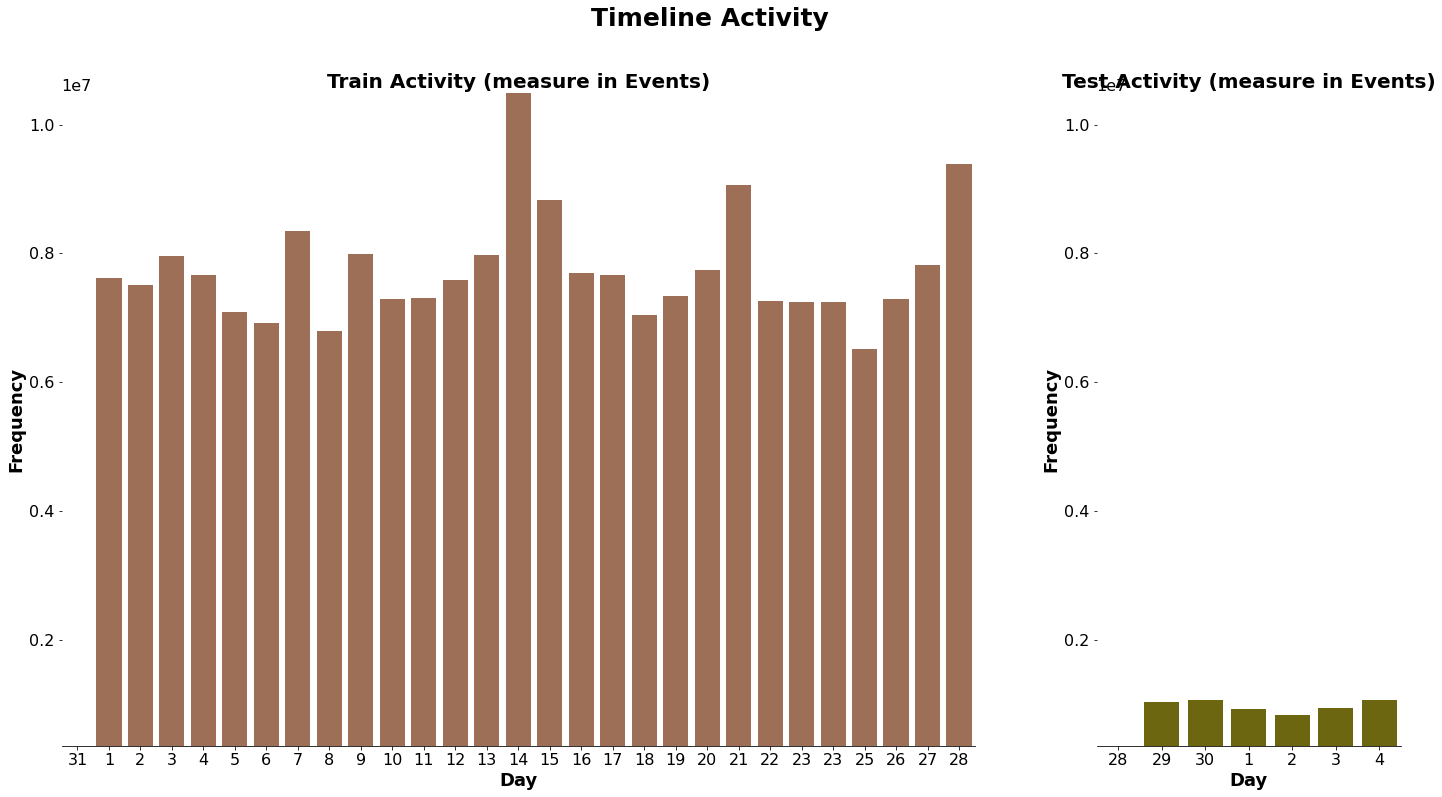

In [40]:
activity1 = train["day"].value_counts().reset_index().to_pandas()
activity2 = test["day"].value_counts().reset_index().to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12), gridspec_kw={'width_ratios': [3, 1]})
axs = [ax1, ax2]
fig.suptitle('Timeline Activity', 
             weight="bold", size=25)

sns.barplot(data=activity1, x="index", y="day", lw=3, color=my_colors[1], 
            order=[31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                   16, 17, 18, 19, 20, 21, 22, 23, 23, 25, 26, 27, 28], ax=ax1)
# show_values_on_bars(ax1, h_v="v", space=0.4)
ax1.set_title('Train Activity (measure in Events)', weight="bold", size=20)

sns.barplot(data=activity2, x="index", y="day", lw=3, color=my_colors[5],
            order = [28, 29, 30, 1, 2, 3, 4])
# show_values_on_bars(ax2, h_v="v", space=0.4)
ax2.set_title('Test Activity (measure in Events)', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Day", size = 18, weight="bold")
    ax.set_ylabel("Frequency", size = 18, weight="bold")
    ax.set_ylim(activity1["day"].min(), activity1["day"].max())
    
sns.despine(right=True, top=True, left=True);

In [41]:
create_wandb_plot(x_data=activity1["index"],
                  y_data=activity1["day"],
                  x_name="Day", y_name="Frequency",
                  title="Train Activity (measure in Events)",
                  log="bar_tr_activity", plot="bar")

create_wandb_plot(x_data=activity2["index"],
                  y_data=activity2["day"],
                  x_name="Day", y_name="Frequency",
                  title="Test Activity (measure in Events)",
                  log="bar_te_activity", plot="bar")

**Q**: But what about only for orders? How does the month activity looks like?

**A**: They look about the same, with an outlier on 9th August (a Tuesday).

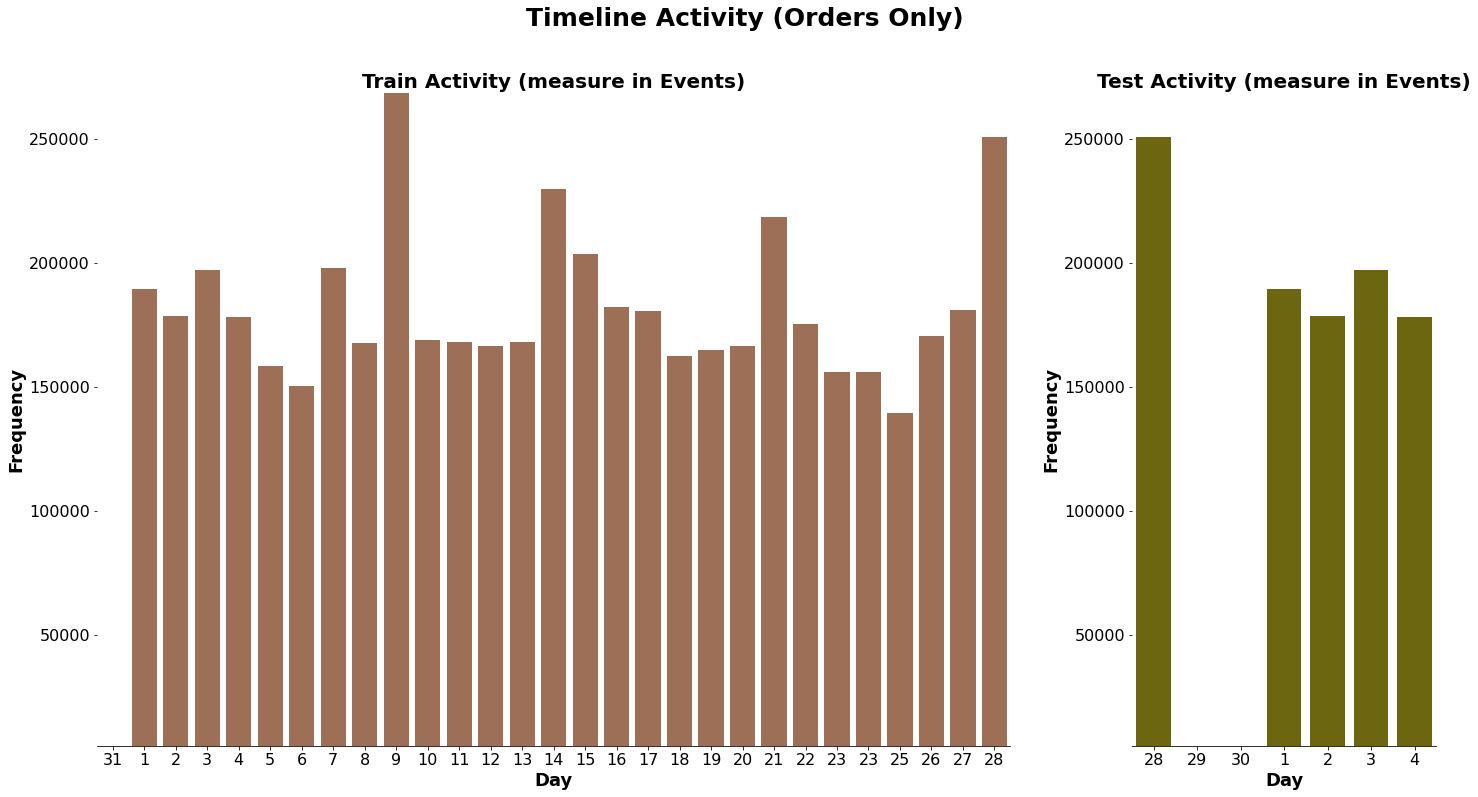

In [42]:
activity1 = train[train["type"]==2]["day"].value_counts().reset_index().to_pandas()
activity2 = train[train["type"]==2]["day"].value_counts().reset_index().to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12), gridspec_kw={'width_ratios': [3, 1]})
axs = [ax1, ax2]
fig.suptitle('Timeline Activity (Orders Only)', 
             weight="bold", size=25)

sns.barplot(data=activity1, x="index", y="day", lw=3, color=my_colors[1], 
            order=[31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                   16, 17, 18, 19, 20, 21, 22, 23, 23, 25, 26, 27, 28], ax=ax1)
# show_values_on_bars(ax1, h_v="v", space=0.4)
ax1.set_title('Train Activity (measure in Events)', weight="bold", size=20)

sns.barplot(data=activity2, x="index", y="day", lw=3, color=my_colors[5],
            order = [28, 29, 30, 1, 2, 3, 4])
# show_values_on_bars(ax2, h_v="v", space=0.4)
ax2.set_title('Test Activity (measure in Events)', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Day", size = 18, weight="bold")
    ax.set_ylabel("Frequency", size = 18, weight="bold")
    ax.set_ylim(activity1["day"].min(), activity1["day"].max())
    
sns.despine(right=True, top=True, left=True);

**Q**: Is there **less or more activity during the night**? (aka is there a pattern in events number that correlates to the time of day?)

**A**: Distributions are extremely similar. There is a steady increase throughout the day, with the lowest activity in the morning and noon, and the highest in the afternoon (between 5PM and 7PM).

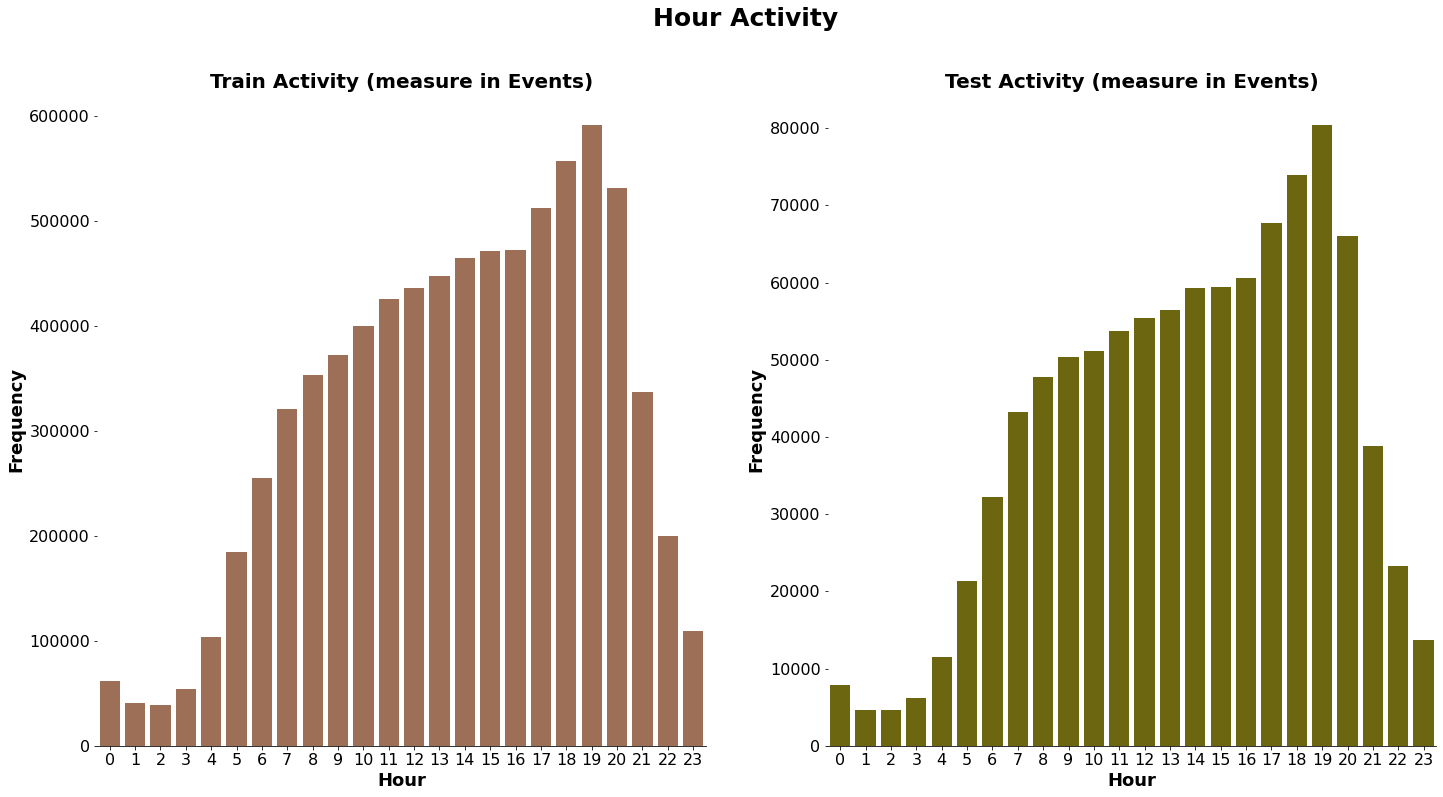

In [43]:
hours1 = train.groupby(["day", "hour", "night"])["session"].count()\
            .reset_index().groupby(["hour", "night"])["session"]\
            .mean().reset_index().to_pandas()
hours2 = test.groupby(["day", "hour", "night"])["session"].count()\
            .reset_index().groupby(["hour", "night"])["session"]\
            .mean().reset_index().to_pandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12), gridspec_kw={'width_ratios': [2, 2]})
axs = [ax1, ax2]
fig.suptitle('Hour Activity', 
             weight="bold", size=25)

sns.barplot(data=hours1, x="hour", y="session", lw=3, color=my_colors[1], ax=ax1)
# show_values_on_bars(ax1, h_v="v", space=0.4)
ax1.set_title('Train Activity (measure in Events)', weight="bold", size=20)

sns.barplot(data=hours2, x="hour", y="session", lw=3, color=my_colors[5], ax=ax2)
# show_values_on_bars(ax2, h_v="v", space=0.4)
ax2.set_title('Test Activity (measure in Events)', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Hour", size = 18, weight="bold")
    ax.set_ylabel("Frequency", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [44]:
create_wandb_plot(x_data=hours1["hour"],
                  y_data=hours1["session"],
                  x_name="Hour", y_name="Frequency",
                  title="Train (Hour) Activity (measure in Events)",
                  log="bar_tr_hour", plot="bar")

create_wandb_plot(x_data=hours2["hour"],
                  y_data=hours2["session"],
                  x_name="Hour", y_name="Frequency",
                  title="Test (Hour) Activity (measure in Events)",
                  log="bar_te_hour", plot="bar")

**Q**: Do the users (sessions) have **registered activity** on 1 hour? 1 Day? Whole month? How does their activity look like?

**A**: Looks like ... it varies!
* ~45% of sessions have registered activity in less than 1 day. Which means more than half of the sessions have activity on 1 or multiple days!
* for the rest it looks like it's an even 10%:
    * ~10% of sessions have registered activity for 5->10 days
    * ~10% of sessions have registered activity for 10->15 days
    * ~10% of sessions have registered activity for 15->20 days
    * ~10% of sessions have registered activity for 20->25 days
* we have some strong outliers too, with ~4% of sessions having 25+ days of registered activity

In [45]:
# Get min and max time for each session
sess_time = train.groupby("session").aggregate({"ts": ["min", "max"]}).reset_index()
sess_time.columns = ["session", "min_ts", "max_ts"]

# Get time difference
sess_time["diff"] = cudf.to_datetime(sess_time["max_ts"], unit="s") - \
                    cudf.to_datetime(sess_time["min_ts"], unit="s")
# Convert difference in days
# days are floats as I also added the hours to them
sess_time["diff"] = sess_time["diff"].dt.components["hours"]/24 + sess_time["diff"].dt.days

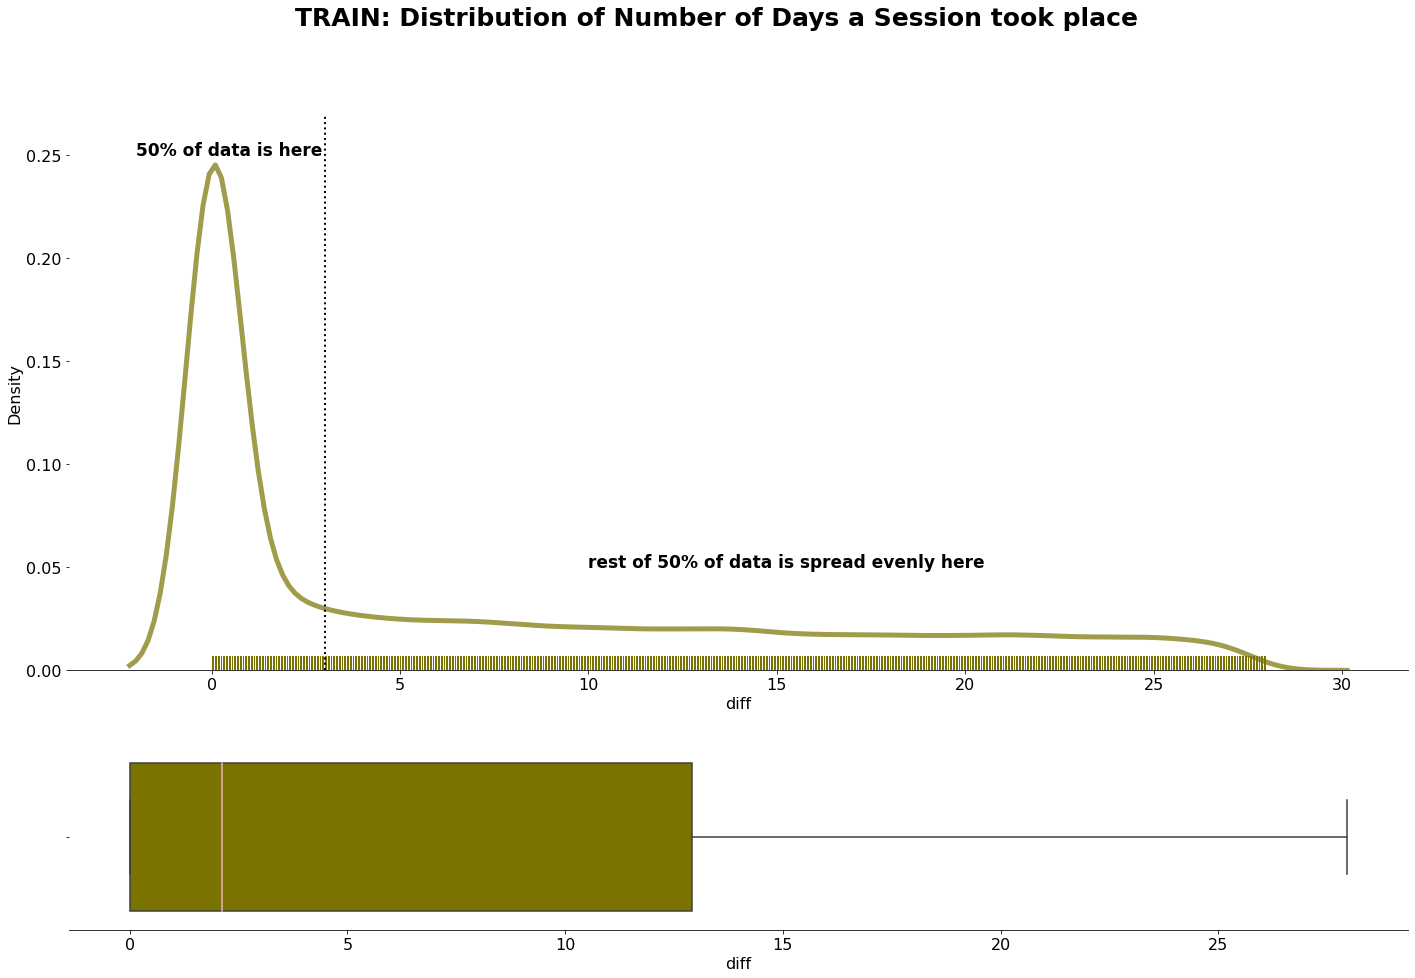

In [46]:
sess = sess_time["diff"][::60].copy()
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(sess.to_pandas(), rug=True, hist=False, 
#              bins=10,
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[5]},
             ax=a0)

a0.axvline(x=3, ls=":", lw=2, color="black")
a0.text(x=-2, y=0.25, s="50% of data is here", size=17, color="black", weight="bold")
a0.text(x=10, y=0.05, s="rest of 50% of data is spread evenly here", size=17, color="black", weight="bold")

sns.boxplot(x=sess.to_pandas(), ax=a1, notch=False, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": my_colors[5]},
            medianprops={"color": my_colors[0]},)

plt.suptitle("TRAIN: Distribution of Number of Days a Session took place", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

**Q**: We looked at an user overall activity (from the first event to the last). Now I wanna see for some of them **how is the intensity**? Do they have more events (clicks, carts, orders) at the beginning and fade away? Or are they constant?

**A**: Honestly, I do not have an e xact answer here. Majority of sessions seen below have a spike of activity in the first day and then another one in the last day (looks like they looked once at the beginning and then again - maybe even ordered - in the last day). However it's not always tha case, other sessions have a latent activity over the entire period, so here I cannot conclude something very ... speciffic.

In [47]:
def get_session_activity(sess_example):
    # Filter only needed session
    dt = train[train["session"] == sess_example]["day"].value_counts().reset_index()
    dt.columns=["day", "activity_count"]

    # Append 0 for any days that are missing
    # So the lineplot is accurate
    for k in range(1, 30):
        if k not in dt["day"]:
            dt = dt.append({"day":k, "activity_count":0}, ignore_index=True)

    # Plot
    plt.figure(figsize=(20, 8))
    plt.title(f"Session {sess_example}: activity over days", weight="bold", size=25)
    sns.lineplot(data=dt.to_pandas(), x="day", y="activity_count",
                 color=my_colors[1], lw=10)
    plt.xlabel("Day", size = 18, weight="bold")
    plt.ylabel("Activity Count (in events)", size = 18, weight="bold")
    sns.despine(right=True, top=True, left=True)
    plt.show()

### Low Activity - <= 5 days

Session that had activity for 4 days: 



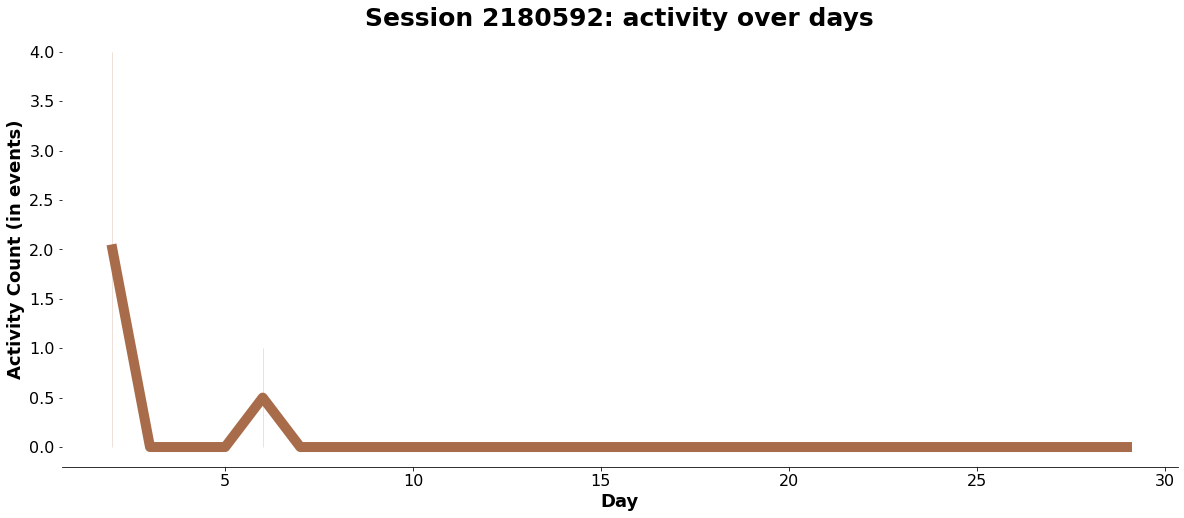

In [48]:
print(clr.S+"Session that had activity for 4 days:"+clr.E, "\n")
get_session_activity(sess_example=sess_time[sess_time["diff"]==4]["session"].values.tolist()[0])

Session that had activity for 5 days: 



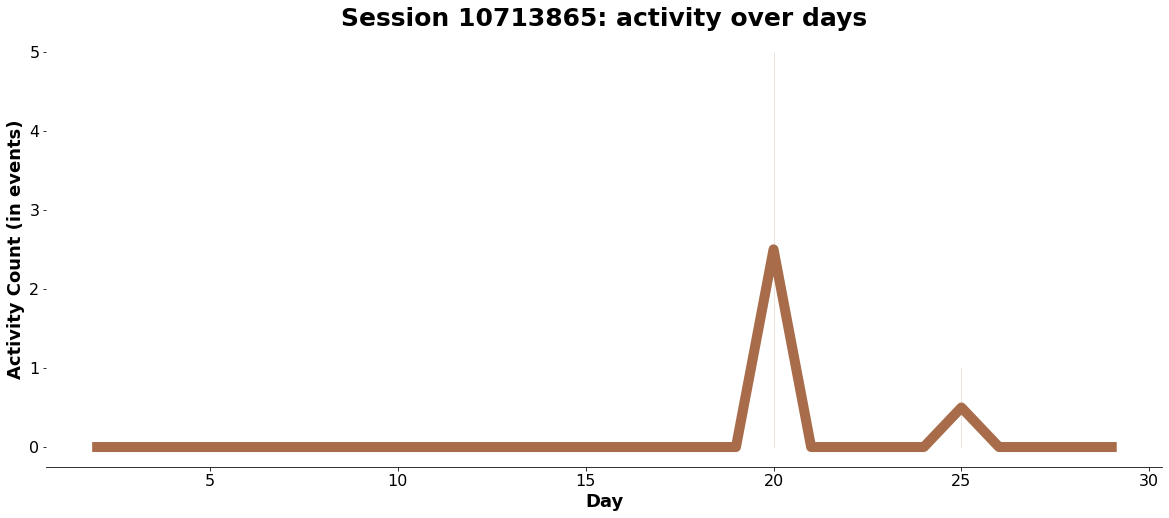

In [49]:
print(clr.S+"Session that had activity for 5 days:"+clr.E, "\n")
get_session_activity(sess_example=sess_time[sess_time["diff"]==5]["session"].values.tolist()[0])

### Mediun Activity - 5 -> 15 days

Session that had activity for 7 days: 



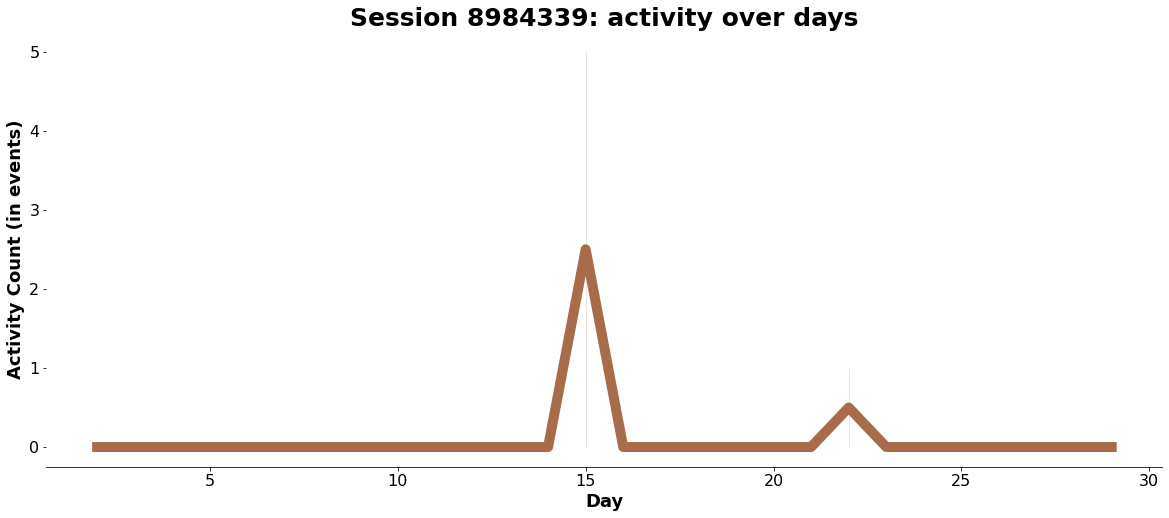

In [50]:
print(clr.S+"Session that had activity for 7 days:"+clr.E, "\n")
get_session_activity(sess_example=sess_time[sess_time["diff"]==7]["session"].values.tolist()[0])

Session that had activity for 10 days: 



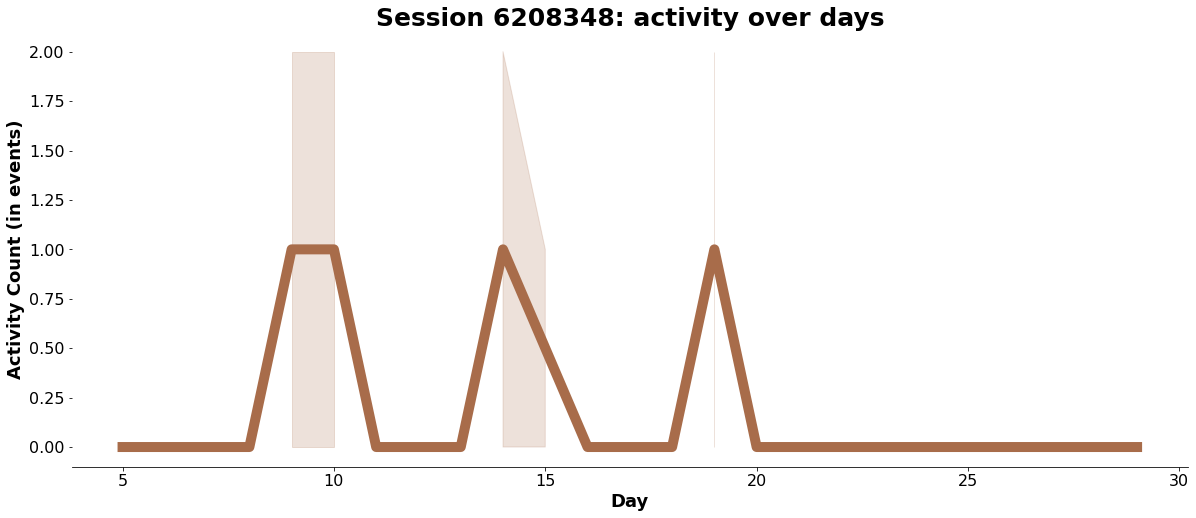

In [51]:
print(clr.S+"Session that had activity for 10 days:"+clr.E, "\n")
get_session_activity(sess_example=sess_time[sess_time["diff"]==10]["session"].values.tolist()[0])

### High Activity - 15+ days

Activity for a session that had activity for 25 days


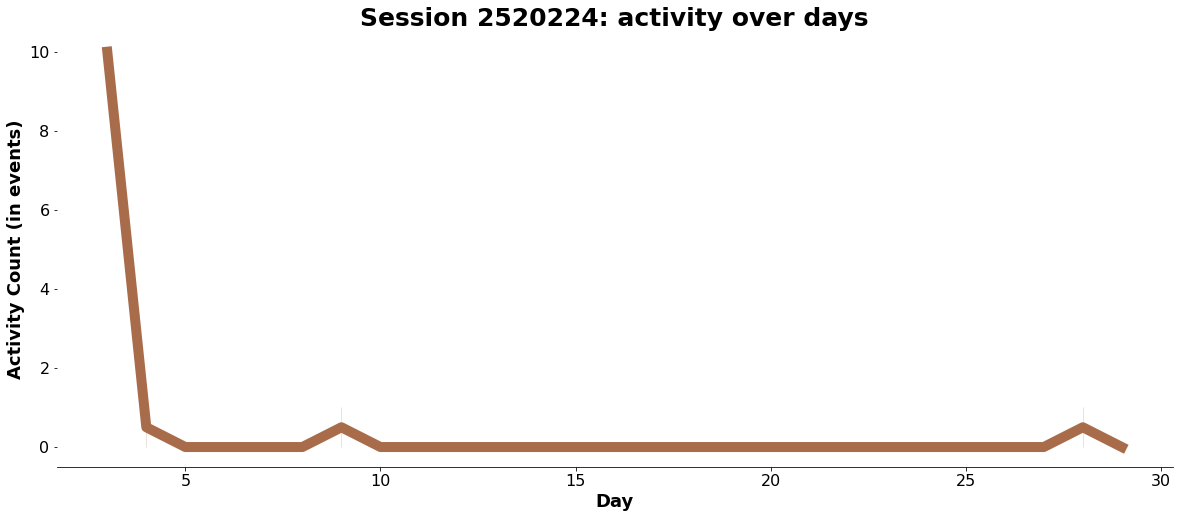

In [52]:
print(clr.S+"Activity for a session that had activity for 25 days"+clr.E)
get_session_activity(sess_example=sess_time[sess_time["diff"]==25]["session"].values.tolist()[1])

Activity for a session that had activity for 26 days


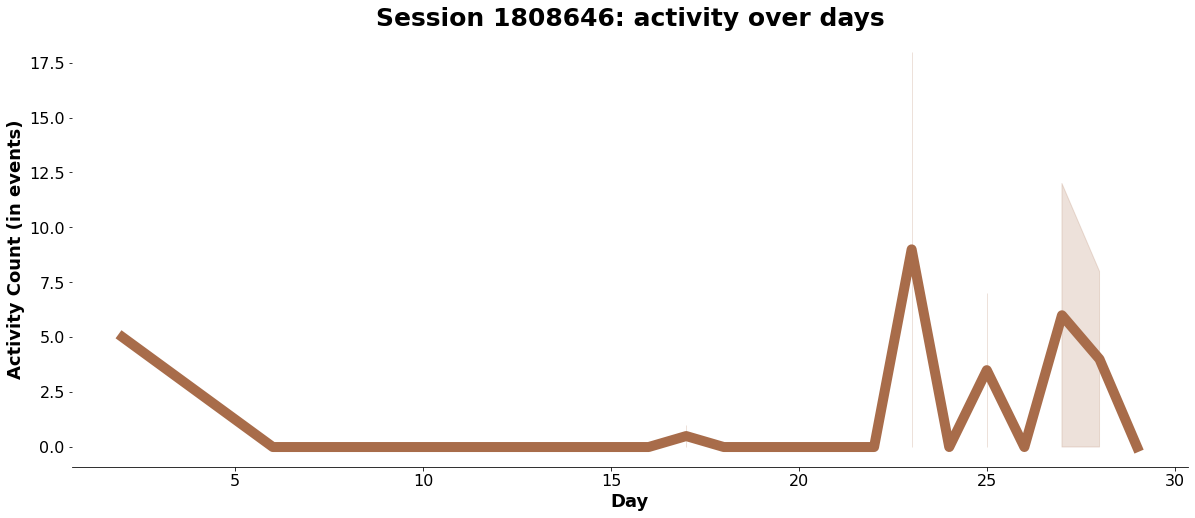

In [53]:
print(clr.S+"Activity for a session that had activity for 26 days"+clr.E)
get_session_activity(sess_example=sess_time[sess_time["diff"]==26]["session"].values.tolist()[1])

In [54]:
del sess_time
gc.collect()

18950

In [55]:
wandb.finish()

# 4. Item Analysis (aid)

* `train`: 1,855,603 unique products
* `test`: 783,486 unique products
* there is no product in the test set that doesn't appear at least once in the train set

<center><img src="https://i.imgur.com/VQLrSGL.jpg" width=800></center>

In [56]:
# 🐝 Experiment
run = wandb.init(project='Otto', name='product_look', config=CONFIG)

In [57]:
# Products Overview
print(clr.S+"Train - Unique products:"+clr.E, train["aid"].nunique())
print(clr.S+"Test - Unique products:"+clr.E, test["aid"].nunique())
print(clr.S+"Products Found in Test & Train:"+clr.E,
     len(set(test["aid"].unique().to_pandas())\
         .intersection(set(train["aid"].unique().to_pandas()))))
print(clr.S+"Products in Test but not in Train:"+clr.E, 
      test["aid"].nunique() - len(set(test["aid"].unique().to_pandas())\
                                     .intersection(set(train["aid"].unique().to_pandas()))))

wandb.log({"new_in_test": test["aid"].nunique() - len(set(test["aid"].unique().to_pandas())\
                                     .intersection(set(train["aid"].unique().to_pandas())))})

Train - Unique products: 1855603
Test - Unique products: 783486
Products Found in Test & Train: 783486
Products in Test but not in Train: 0


**Q**: Do products repeat in a same patterns, or are there products that have more **interaction** than others?

**A**: Vast majority (62% in `train`) of products are seen **less than 30 times** within the dataset. There are however some pretty strong outliers.

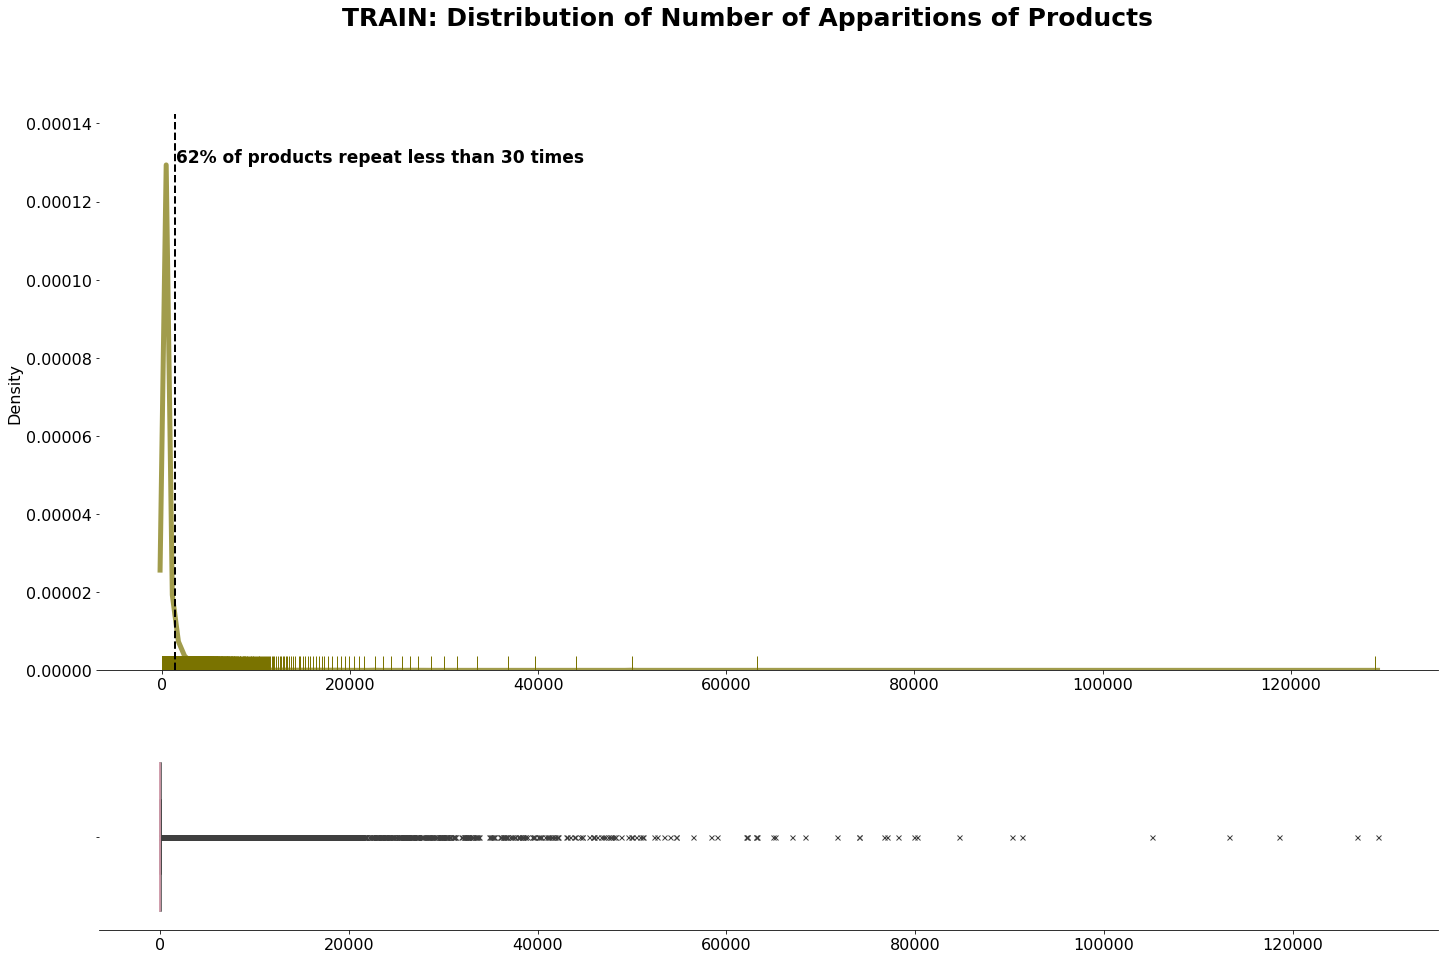

In [58]:
sess = train["aid"].value_counts().values
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(sess[::20].get(), rug=True, hist=False, 
#              bins=10,
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[5]},
             ax=a0)

a0.axvline(x=1300, ls="--", lw=2, color="black")
a0.text(x=1500, y=0.00013, s="62% of products repeat less than 30 times",
        size=17, color="black", weight="bold")

sns.boxplot(x=sess.get(), ax=a1, notch=False, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": my_colors[5]},
            medianprops={"color": my_colors[0]},)

plt.suptitle("TRAIN: Distribution of Number of Apparitions of Products", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [59]:
create_wandb_hist(x_data=sess[::20].tolist(), 
                  x_name="Number of Apparitions / Product",
                  title="TRAIN: Distribution of Number of Apparitions of Products",
                  log="hist_product_tr")

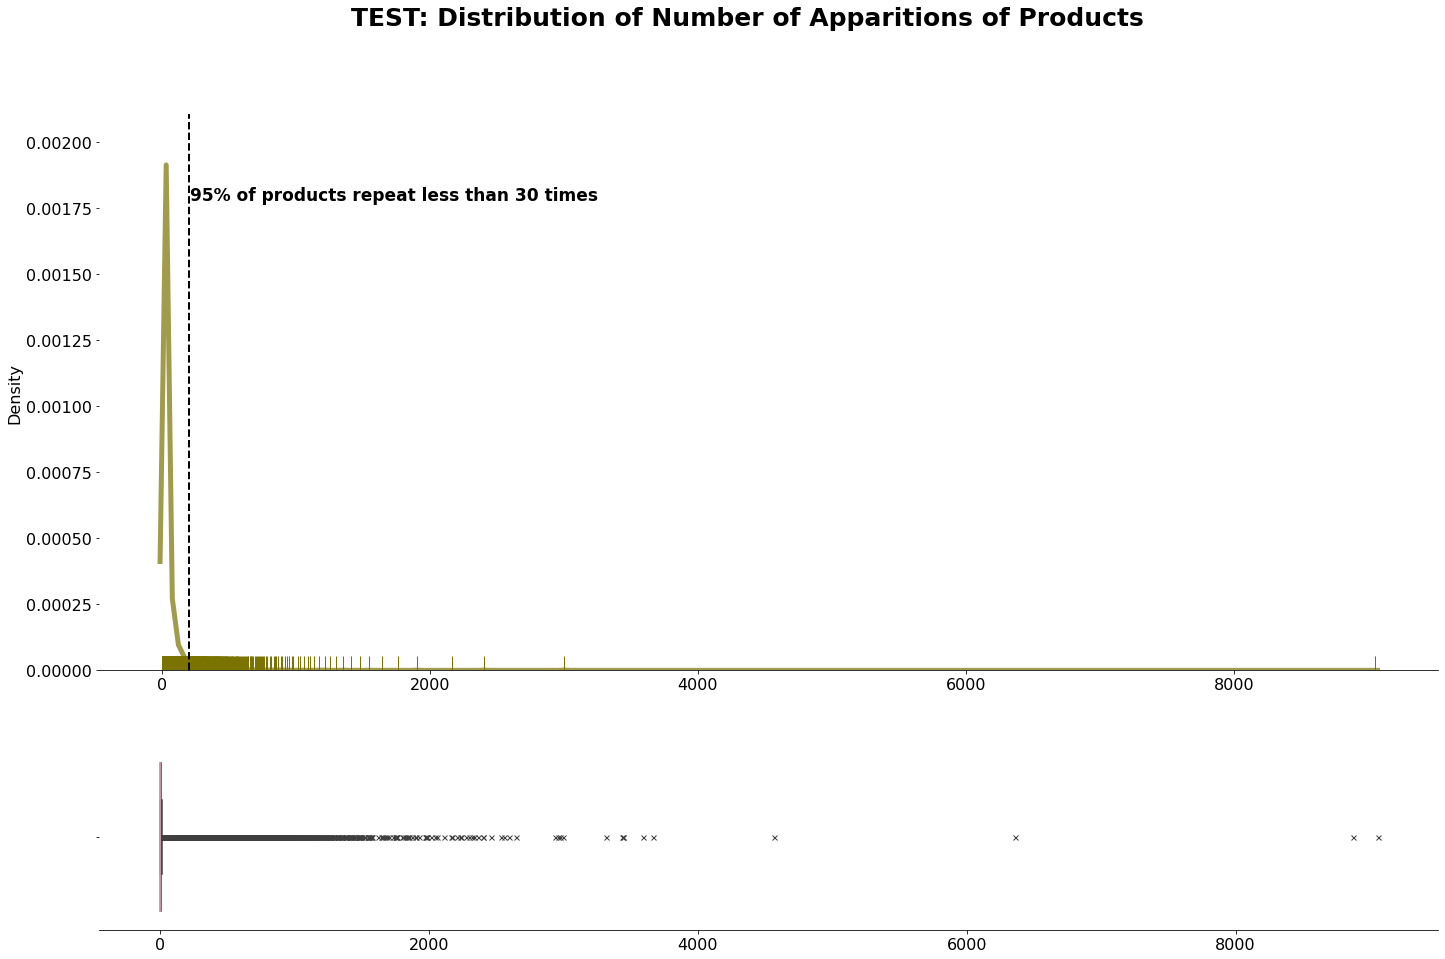

In [60]:
sess = test["aid"].value_counts().values
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 15))
sns.distplot(sess[::10].get(), rug=True, hist=False, 
#              bins=10,
             rug_kws={"color": my_colors[5]},
             kde_kws={"color": my_colors[5], "lw": 5, "alpha": 0.7},
#              hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": my_colors[5]},
             ax=a0)

a0.axvline(x=200, ls="--", lw=2, color="black")
a0.text(x=210, y=0.00178, s="95% of products repeat less than 30 times",
        size=17, color="black", weight="bold")

sns.boxplot(x=sess.get(), ax=a1, notch=False, showcaps=True, 
            flierprops={"marker": "x"},
            boxprops={"facecolor": my_colors[5]},
            medianprops={"color": my_colors[0]},)

plt.suptitle("TEST: Distribution of Number of Apparitions of Products", weight="bold", size=25)
sns.despine(right=True, top=True, left=True);

In [61]:
create_wandb_hist(x_data=sess[::10].tolist(), 
                  x_name="Number of Apparitions / Product",
                  title="TEST: Distribution of Number of Apparitions of Products",
                  log="hist_product_te")

**Q**: Do the products with most events have **same interactions** in train and test? In other words, do the products that are most viewed in train also have a similar pattern in test data? What about on events alone?

**A**: On first glance (top 25 products) they do. 9/25 top products (with most interactions) appear in Train and Test (looking at the overall engagement). For "add to cart" the similarity is even stronger, with 14/25 aids being in boths Train and Test.

In [62]:
# Top products to show
N = 25

Top products in both Train and Test: {'554660', '1022566', '29735', '832192', '1460571', '485256', '184976', '986164', '108125'}


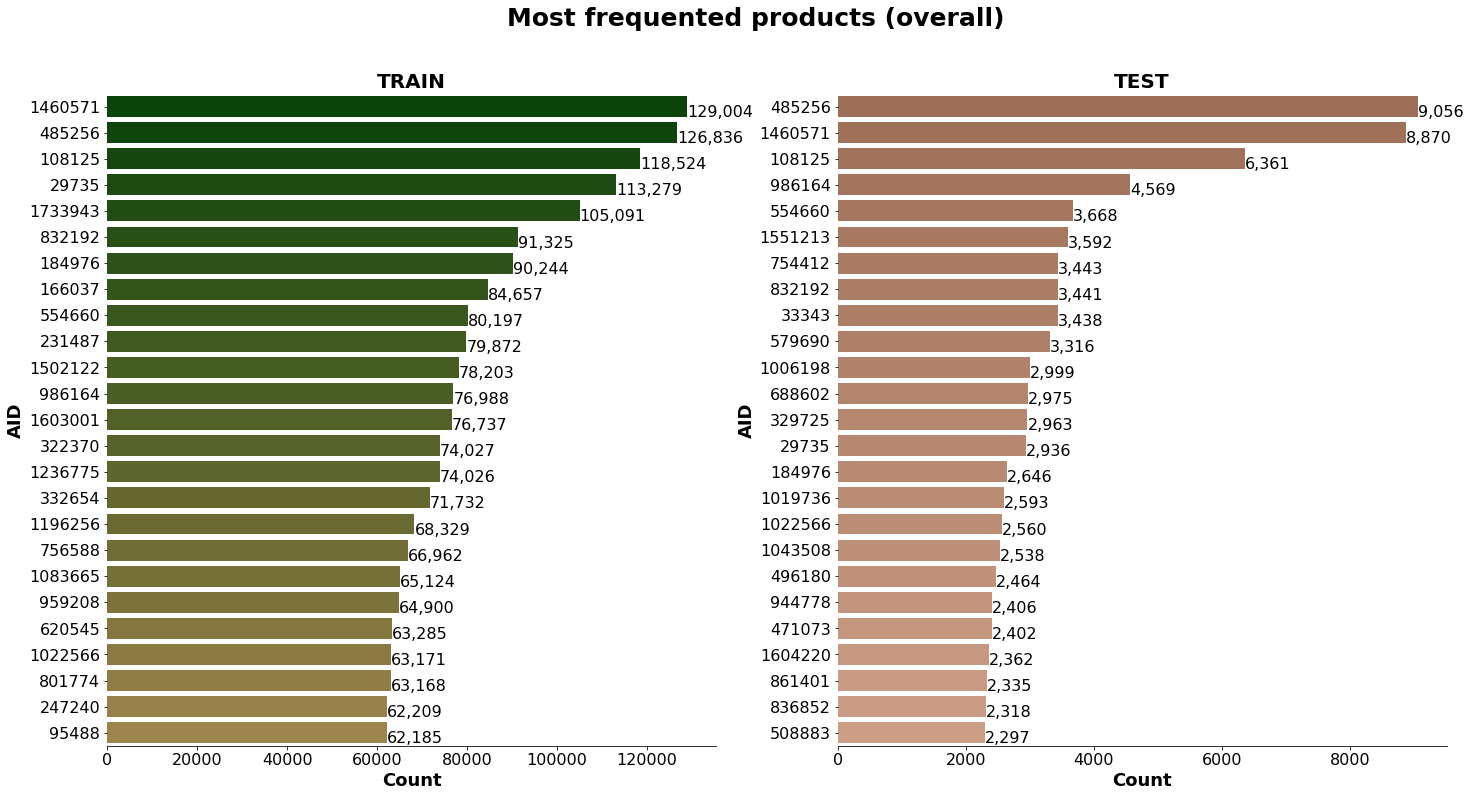

In [63]:
dt_tr = train["aid"].value_counts().head(N).reset_index()
dt_tr.columns = ["aid", "count"]
dt_tr["aid"] = dt_tr["aid"].astype(str)

dt_te = test["aid"].value_counts().head(N).reset_index()
dt_te.columns = ["aid", "count"]
dt_te["aid"] = dt_te["aid"].astype(str)

print(clr.S+f"Top products in both Train and Test:"+clr.E, 
      set(dt_tr["aid"].unique().to_pandas())\
            .intersection(set(dt_te["aid"].unique().to_pandas())))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
axs = [ax1, ax2]
fig.suptitle('Most frequented products (overall)', 
             weight="bold", size=25)

sns.barplot(data=dt_tr.to_pandas(), x="count", y="aid", ax=ax1,
            palette = sns.blend_palette(colors = [my_colors[6], my_colors[4]], n_colors=N))
show_values_on_bars(ax1, h_v="h", space=0.4)
ax1.set_title('TRAIN', weight="bold", size=20)

sns.barplot(data=dt_te.to_pandas(), x="count", y="aid", ax=ax2,
            palette = sns.blend_palette(colors = [my_colors[1], my_colors[3]], n_colors=N))
show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_title('TEST', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Count", size = 18, weight="bold")
    ax.set_ylabel("AID", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [66]:
type_value = 0

Top products in both Train and Test: {'554660', '166037', '544144', '1022566', '332654', '29735', '832192', '485256', '152547', '1460571', '986164', '258353', '33343'}


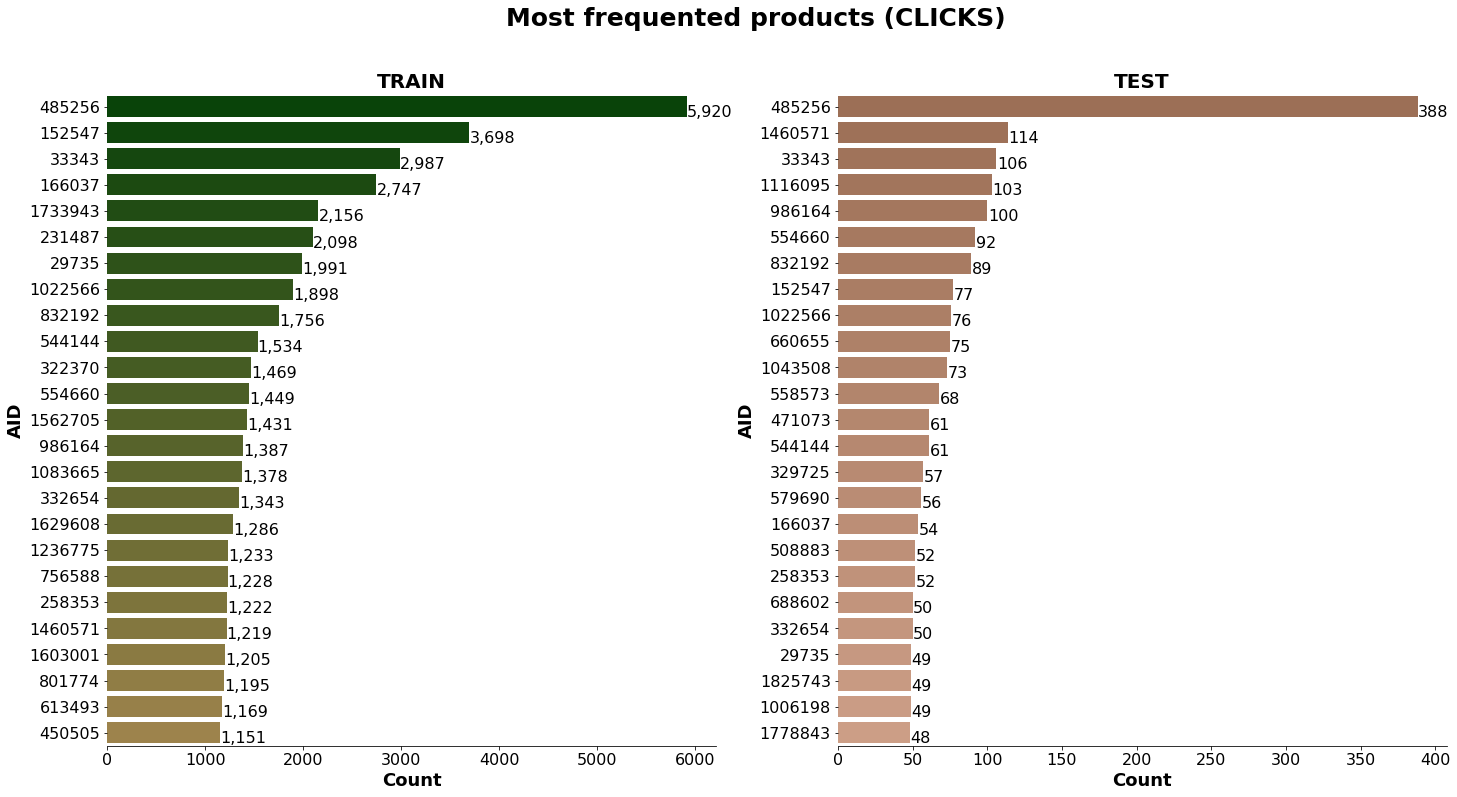

In [80]:
# dt_tr = train[train["type"]==type_value]["aid"].value_counts().head(N).reset_index()
# dt_tr.columns = ["aid", "count"]
# dt_tr["aid"] = dt_tr["aid"].astype(str)

# dt_te = test[test["type"]==type_value]["aid"].value_counts().head(N).reset_index()
# dt_te.columns = ["aid", "count"]
# dt_te["aid"] = dt_te["aid"].astype(str)

# Select a smaller subset of the data
train_sample = train.sample(frac=0.2)  # Use 10% of the data
test_sample = test.sample(frac=0.2)

dt_tr = train_sample[train_sample["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_tr.columns = ["aid", "count"]
dt_tr["aid"] = dt_tr["aid"].astype(str)

dt_te = test_sample[test_sample["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_te.columns = ["aid", "count"]
dt_te["aid"] = dt_te["aid"].astype(str)

print(clr.S+f"Top products in both Train and Test:"+clr.E, 
      set(dt_tr["aid"].unique().to_pandas())\
            .intersection(set(dt_te["aid"].unique().to_pandas())))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
axs = [ax1, ax2]
fig.suptitle(f'Most frequented products (CLICKS)', 
             weight="bold", size=25)

sns.barplot(data=dt_tr.to_pandas(), x="count", y="aid", ax=ax1,
            palette = sns.blend_palette(colors = [my_colors[6], my_colors[4]], n_colors=N))
show_values_on_bars(ax1, h_v="h", space=0.4)
ax1.set_title('TRAIN', weight="bold", size=20)

sns.barplot(data=dt_te.to_pandas(), x="count", y="aid", ax=ax2,
            palette = sns.blend_palette(colors = [my_colors[1], my_colors[3]], n_colors=N))
show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_title('TEST', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Count", size = 18, weight="bold")
    ax.set_ylabel("AID", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [69]:
type_value = 1

Top products in both Train and Test: {'554660', '166037', '544144', '1022566', '1462420', '332654', '29735', '832192', '485256', '152547', '1460571', '986164', '258353', '33343'}


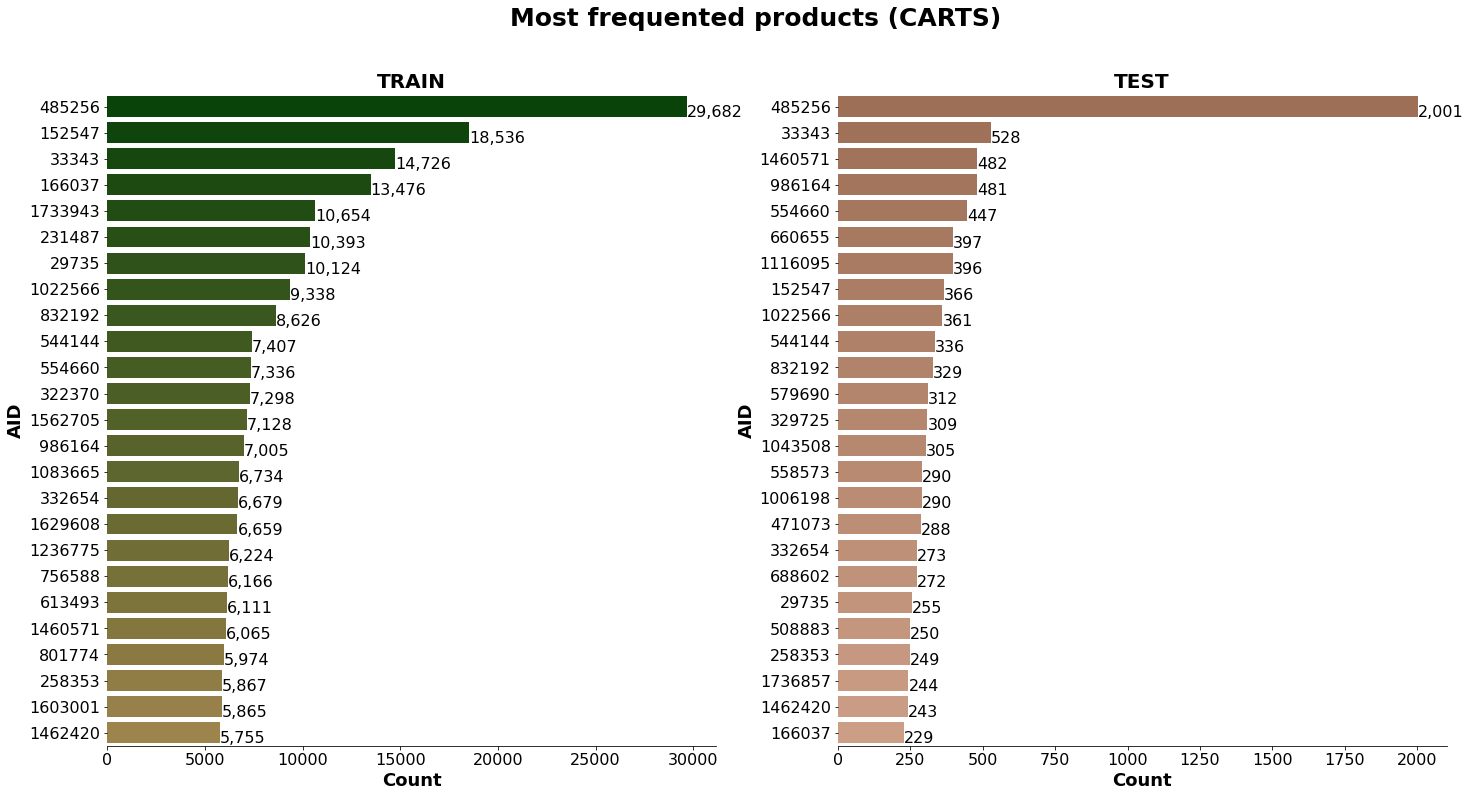

In [83]:
# Select a smaller subset of the data
train_sample = train.sample(frac=0.75)  # Use 10% of the data
test_sample = test.sample(frac=0.75)
dt_tr = train[train["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_tr.columns = ["aid", "count"]
dt_tr["aid"] = dt_tr["aid"].astype(str)

dt_te = test[test["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_te.columns = ["aid", "count"]
dt_te["aid"] = dt_te["aid"].astype(str)

print(clr.S+f"Top products in both Train and Test:"+clr.E, 
      set(dt_tr["aid"].unique().to_pandas())\
            .intersection(set(dt_te["aid"].unique().to_pandas())))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
axs = [ax1, ax2]
fig.suptitle(f'Most frequented products (CARTS)', 
             weight="bold", size=25)

sns.barplot(data=dt_tr.to_pandas(), x="count", y="aid", ax=ax1,
            palette = sns.blend_palette(colors = [my_colors[6], my_colors[4]], n_colors=N))
show_values_on_bars(ax1, h_v="h", space=0.4)
ax1.set_title('TRAIN', weight="bold", size=20)

sns.barplot(data=dt_te.to_pandas(), x="count", y="aid", ax=ax2,
            palette = sns.blend_palette(colors = [my_colors[1], my_colors[3]], n_colors=N))
show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_title('TEST', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Count", size = 18, weight="bold")
    ax.set_ylabel("AID", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

In [84]:
type_value = 2

Top products in both Train and Test: {'166037', '544144', '1022566', '923948', '332654', '29735', '986164'}


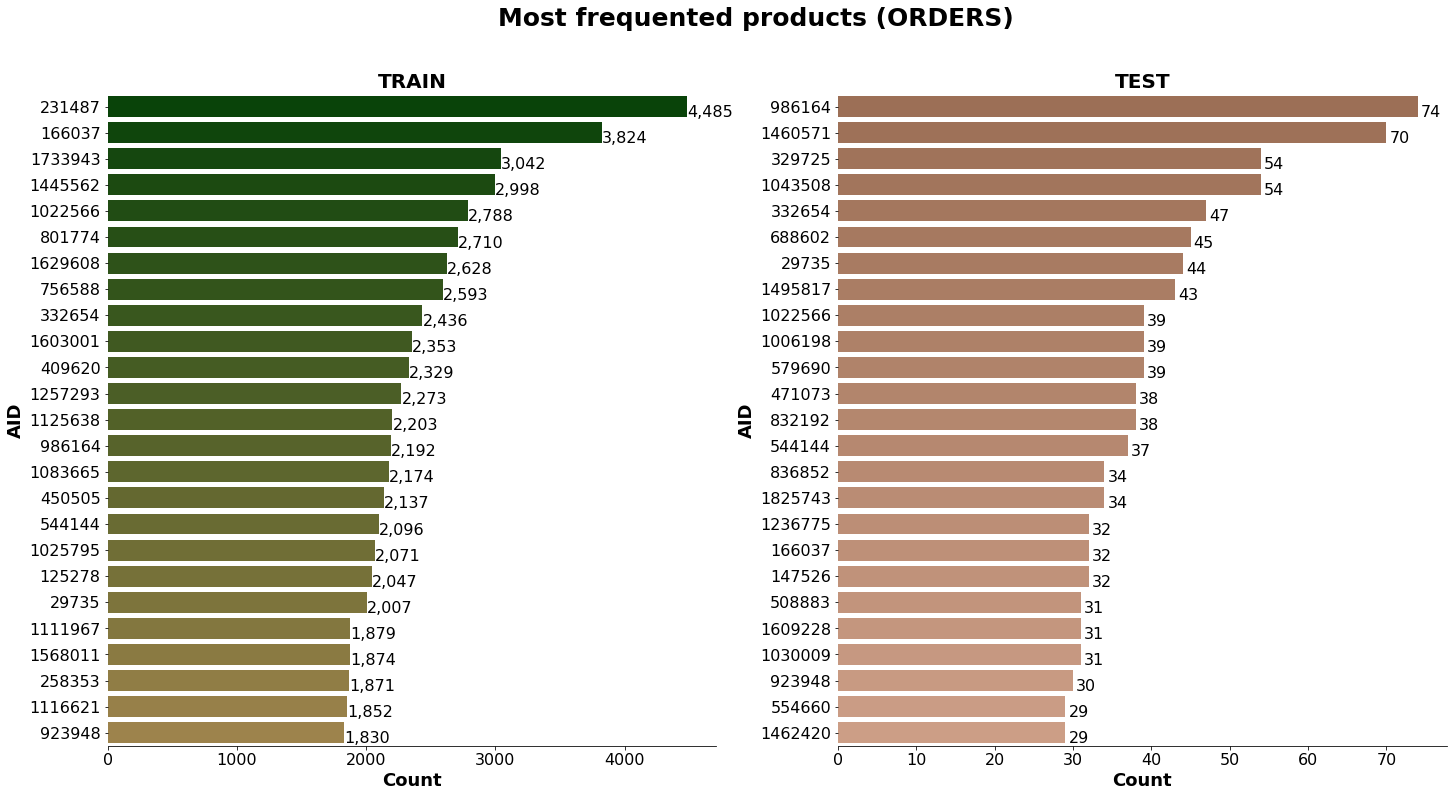

In [85]:
dt_tr = train[train["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_tr.columns = ["aid", "count"]
dt_tr["aid"] = dt_tr["aid"].astype(str)

dt_te = test[test["type"]==type_value]["aid"].value_counts().head(N).reset_index()
dt_te.columns = ["aid", "count"]
dt_te["aid"] = dt_te["aid"].astype(str)

print(clr.S+f"Top products in both Train and Test:"+clr.E, 
          set(dt_tr["aid"].unique().to_pandas())\
                .intersection(set(dt_te["aid"].unique().to_pandas())))

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
axs = [ax1, ax2]
fig.suptitle(f'Most frequented products (ORDERS)', 
             weight="bold", size=25)

sns.barplot(data=dt_tr.to_pandas(), x="count", y="aid", ax=ax1,
            palette = sns.blend_palette(colors = [my_colors[6], my_colors[4]], n_colors=N))
show_values_on_bars(ax1, h_v="h", space=0.4)
ax1.set_title('TRAIN', weight="bold", size=20)

sns.barplot(data=dt_te.to_pandas(), x="count", y="aid", ax=ax2,
            palette = sns.blend_palette(colors = [my_colors[1], my_colors[3]], n_colors=N))
show_values_on_bars(ax2, h_v="h", space=0.4)
ax2.set_title('TEST', weight="bold", size=20)

for ax in axs:
#     ax.set_yticks([])
    ax.set_xlabel("Count", size = 18, weight="bold")
    ax.set_ylabel("AID", size = 18, weight="bold")
    
sns.despine(right=True, top=True, left=True);

📍 So there are quite a few products that appear in both Train and Test when looking at top 25 prods with most event types:
* CLICKS: {'108125', '554660', '832192', '184976', '29735', '986164', '1460571', '485256'}
* CARTS: {'33343', '152547', '554660', '832192', '29735', '258353', '986164', '544144', '1022566', '332654', '1462420', '1460571', '166037', '485256'}
* ORDERS: {'923948', '29735', '1022566', '986164', '544144', '332654', '166037'}

**Q**: What about first 1000 products? What about their pairing? Can we find some rules?

In [86]:
wandb.finish()

# 5. Baseline - Predict Top Clicks/Carts/Orders

📍 **Note**: We can predict up to 20 products for each type (we won't be penalized for predicting more than necessary). So, for a dummy baseline, I will predict for each session and type most common aids in each type.

In [90]:
# Select a smaller subset of the data
train_sample = train.sample(frac=0.1)  # Use 10% of the data
test_sample = test.sample(frac=0.1)

# Get top N products for each type for train
groups = train.groupby(["aid", "type"])["night"].count().reset_index()\
        .sort_values(["type", "night"], ascending=False).reset_index(drop=True)
groups.columns = ["aid", "type", "count"]

N = 60
clicks = groups[groups["type"]==0].head(N)["aid"].values.tolist()
carts = groups[groups["type"]==1].head(N)["aid"].values.tolist()
orders = groups[groups["type"]==2].head(N)["aid"].values.tolist()

print(clr.S+"(Clicks) Top Aids:"+clr.E, clicks)
print(clr.S+"(Carts) Top Aids:"+clr.E, carts)
print(clr.S+"(Orders) Top Aids:"+clr.E, orders)

(Clicks) Top Aids: [1460571, 108125, 29735, 485256, 1733943, 184976, 832192, 1502122, 554660, 1603001, 986164, 166037, 322370, 1236775, 231487, 959208, 332654, 1196256, 95488, 620545, 756588, 1645990, 1083665, 247240, 673407, 801774, 1586171, 1022566, 1294924, 508883, 811371, 1116095, 102345, 530377, 1604220, 892871, 199409, 1197632, 1796103, 670006, 714524, 819288, 612920, 1531805, 632365, 1498443, 496180, 584027, 399315, 1743151, 409620, 636101, 1257293, 1647563, 794192, 984459, 861401, 500609, 1365988, 77440]
(Carts) Top Aids: [485256, 152547, 33343, 166037, 1733943, 231487, 29735, 1022566, 832192, 544144, 554660, 322370, 1562705, 986164, 1083665, 332654, 1629608, 1236775, 756588, 613493, 1460571, 801774, 258353, 1603001, 1462420, 1445562, 450505, 1498443, 1111967, 1257293, 409620, 892871, 673407, 508883, 530377, 1025795, 247240, 923948, 1568011, 1043508, 1125638, 77440, 1636724, 634452, 1116095, 500609, 125278, 1531805, 1743151, 1196256, 1406660, 1502122, 1586171, 11830, 184976, 16

In [91]:
# Sample Submission
ss = cudf.read_csv("/kaggle/input/otto-recommender-system/sample_submission.csv")
ss.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


## Submission 1: Top 20 products (repeating)

📍**Note**: For the first submission I will just predict top 20 products, without looking at the user's activity before (hence, if session 9999 in test clicked on product 001 and product 001 is also in top 20, I will still consider it).

*LB Score: 0.006 - EXTREMELY low :), not good*

In [92]:
def get_top_20_repeats(clicks, carts, orders):
    # Make them strings
    # like we're shown in sample submission
    clicks_1 = " ".join(str(v) for v in clicks[:20])
    carts_1 = " ".join(str(v) for v in carts[:20])
    orders_1 = " ".join(str(v) for v in orders[:20])

    labels = []

    for k in tqdm(range(len(ss))):
        sess_type = ss.iloc[k, :]["session_type"][k]

        if "clicks" in sess_type:
            labels.append(clicks_1)
        elif "carts" in sess_type:
            labels.append(carts_1)
        else:
            labels.append(orders_1)
            
    return labels

# Processed this locally
# takes me 20 seconds vs Kaggle env ~20 mins
labels_top20 = np.load("/kaggle/input/otto-helper-data/top_20_repeats.npy")

## Submission 2: Last 20 AIDs

I also wanted to combine [Radek's](https://www.kaggle.com/code/radek1/last-20-aids) last 20 aids solution with my *top 20* labels and see where that leads me. His LB score is **0.464** with that baseline only.

In [93]:
# Radek's Solution
# taking all aids per session in the test set and predicting them as next steps
test_sess_aids = test.to_pandas().groupby('session')['aid'].apply(lambda x: list(x)[-20:])

In [94]:
session_types = ['clicks', 'carts', 'orders']
labels_radek = []

for _, aids in tqdm(test_sess_aids.iteritems()):
    for types in session_types:
        labels_radek.append(' '.join([str(a) for a in aids]))

1671803it [00:09, 171791.86it/s]


In [95]:
# Radek's + top20
# Combining these 2, as Radek's only has in many cases less than 20 total aids predicted
new_labels = []

for l1, l2 in tqdm(zip(labels_radek, labels_top20)):
    new_labels.append(" ".join((l1 + " " + l2).split(" ")[:20]))

5015409it [00:20, 244957.58it/s]


In [96]:
# Clean memory
del labels_radek, labels_top20, test_sess_aids
gc.collect()

69

In [97]:
# Make the submission
ss["labels"] = new_labels
ss.to_csv("submission.csv", index=False)

This leads to a very slight increase from **0.464** to **0.465**. :) Next Notebook will explore more various (and not dummy) approaches.

In [98]:
# 🐝 Save Artifacts
save_dataset_artifact(run_name="save_train_prep", 
                      artifact_name="train_prep",
                      path="/kaggle/input/otto-helper-data/train_prep.parquet",
                      data_type="dataset")
save_dataset_artifact(run_name="save_test_prep", 
                      artifact_name="test_prep",
                      path="/kaggle/input/otto-helper-data/test_prep.parquet",
                      data_type="dataset")

Artifact has been saved successfully.
Artifact has been saved successfully.


In [ ]:
# <center><video src=".mp4" width=800 controls></center>

### 🐝 [W&B Dashboard](https://wandb.ai/andrada/Otto?workspace=user-andrada)
    
<center><img src="https://i.imgur.com/0alEevD.png"></center>

------

<center><img src="https://i.imgur.com/knxTRkO.png"></center>
